# 📝 **Exploring interpretability: GLM and GAM**  

The objective of this notebook is to analyze the results of GLM and GAM focusing on interpretability. For this,  we will explore methods like Feature Importance, partial dependence plot and SHapley Additive exPlanations (SHAP). It´s important to notice that the results and optimizations considered here are explicated in ``Optuna_Results_Analysis_IT_GLM_GAM_SR`` file. 

***

### 📚 **Importing libraries & Data**

In [1]:
import optuna

import pandas as pd
import numpy as np
import math
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.cluster import Birch, BisectingKMeans
from sklearn.preprocessing import StandardScaler

from statsmodels.genmod.families.links import Identity
import statsmodels.api as sm

import pygam
from pygam import s

import shap

In [2]:
#df = pd.read_csv("../data/train.csv")
df= pd.read_csv("train.csv")
display(df)

number_of_elements  mean_atomic_mass  wtd_mean_atomic_mass  \
0                       4         88.944468             57.862692   
1                       5         92.729214             58.518416   
2                       4         88.944468             57.885242   
3                       4         88.944468             57.873967   
4                       4         88.944468             57.840143   
...                   ...               ...                   ...   
21258                   4        106.957877             53.095769   
21259                   5         92.266740             49.021367   
21260                   2         99.663190             95.609104   
21261                   2         99.663190             97.095602   
21262                   3         87.468333             86.858500   

       gmean_atomic_mass  wtd_gmean_atomic_mass  entropy_atomic_mass  \
0              66.361592              36.116612             1.181795   
1              73.132787              36.396602             1.449309   
2              66.361592              36.122509             1.181795   
3              66.361592              36.119560             1.181795   
4              66.361592              36.110716             1.181795   
...                  ...                    ...                  ...   
21258          82.515384              43.135565             1.177145   
21259          64.812662              32.867748             1.323287   
21260          99.433882              95.464320             0.690847   
21261          99.433882              96.901083             0.690847   
21262          82.555758              80.458722             1.041270   

       wtd_entropy_atomic_mass  range_atomic_mass  wtd_range_atomic_mass  \
0                     1.062396          122.90607              31.794921   
1                     1.057755          122.90607              36.161939   
2                     0.975980          122.90607              35.741099   
3                     1.022291          122.90607              33.768010   
4                     1.129224          122.90607              27.848743   
...                        ...                ...                    ...   
21258                 1.254119          146.88130              15.504479   
21259                 1.571630          188.38390               7.353333   
21260                 0.530198           13.51362              53.041104   
21261                 0.640883           13.51362              31.115202   
21262                 0.895229           71.75500              43.144000   

       std_atomic_mass  ...  wtd_mean_Valence  gmean_Valence  \
0            51.968828  ...          2.257143       2.213364   
1            47.094633  ...          2.257143       1.888175   
2            51.968828  ...          2.271429       2.213364   
3            51.968828  ...          2.264286       2.213364   
4            51.968828  ...          2.242857       2.213364   
...                ...  ...               ...            ...   
21258        65.764081  ...          3.555556       3.223710   
21259        69.232655  ...          2.047619       2.168944   
21260         6.756810  ...          4.800000       4.472136   
21261         6.756810  ...          4.690000       4.472136   
21262        29.905282  ...          4.500000       4.762203   

       wtd_gmean_Valence  entropy_Valence  wtd_entropy_Valence  range_Valence  \
0               2.219783         1.368922             1.066221              1   
1               2.210679         1.557113             1.047221              2   
2               2.232679         1.368922             1.029175              1   
3               2.226222         1.368922             1.048834              1   
4               2.206963         1.368922             1.096052              1   
...                  ...              ...                  ...            ...   
21258           3.519911         1.377820             0.913658  

First of all, it´s necessary to make the train test split, using the same seed and test size.

In [3]:
TEST_SIZE = 0.1

In [4]:
X = df.drop(columns="critical_temp")
y = df["critical_temp"]
X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=TEST_SIZE, random_state=1702
    )
y_test = np.clip(y_test, 1e-6, None)
y_train = np.clip(y_train, 1e-6, None)

##### 📊**Target Distribution**

First of all, we need to check the target distribution for all data.

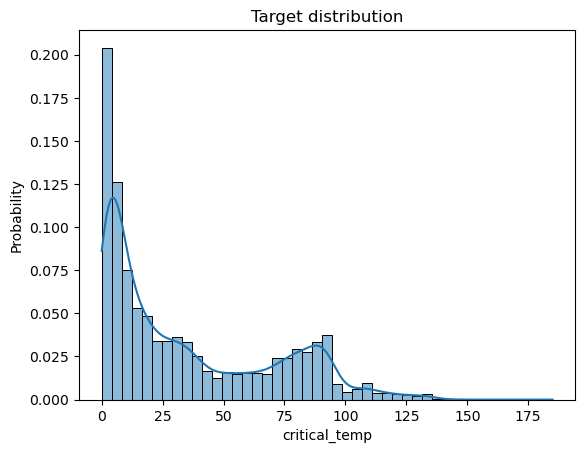

In [5]:
sns.histplot(y, kde=True, stat="probability")  
plt.title("Target distribution")
plt.show()

### **Generalized Linear Models (GLMs)**

<p align="justify">
How can we see, the distribution is very different from a gaussian! This justify the use of a GLM or GAM model, because one of the assumptions of a standard Linear Model is a target that follows a normal distribution. From that, we can analyse the feature importance for a GLM model with all the instances. 
</p>

##### 🔎 **Interpretability and Explicability**

<p align="justify">
Besides the fact that GLMs are linear models, the coefficients interpretation can be prejudiced by the link function used in the GLM trained*. In the reference [1] a method that combines different interpretable measures, as Shapley additive explanations (SHAP), permutation feature importance and quantitatively evaluating partial dependence plots (QPDP) was used for safety climate analysis. Similarly, we can implement these ideas in this case.
</p>

<p align="justify">
Besides that, we can make the analysis with SHapley Additive exPlanations (SHAP), what is a module that is able to explain the contribution of each feature to an individual prediction. By considering all instances, SHAP can determine the overall model importance. This method can be applied as a model-agnostic or type-specific explainer.
</p>

<p align="justify">
The theory behind SHAP is the <em>Game Theory</em>, by Lloyd Shapley. That provides tools for analyzing situations in which parties, called players, make decisions that are interdependent. In the context of machine learning, this theory is applied to measure each player's contribution - in this case, features - to the final outcome - model prediction.
</p>

<p align="justify">
To obtain SHAP values, the first step is to calculate the predictions of a baseline model (i.e., a model that doesn't use any features). Next, for each feature, SHAP computes the change in prediction when that feature is added to a subset of other features. Finally, the contribution of each feature is averaged across all possible combinations. This results in the SHAP value for that feature, which indicates how much it contributed, either positively or negatively, to the model’s prediction. [2][3]
</p>


*To understand why the models are trained with the following parameters, it´s important to check the notebook "Optimization and Hypothesis Testing".
</p>

In [6]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

In [7]:
model = sm.GLM(y_train, X_train_scaled, family=sm.families.Gaussian(link=sm.families.links.Log()))
glm = model.fit()

An important point is the trained GLM does not use a Identity log. Because of that, we need to to use the ``linear`` argument of GLM function, which returns the linear predictor of the mean function (the value before the link function). We need to do that because SHAP wants to see the linear relation between the coefficients.

In [8]:
explainer = shap.Explainer(lambda x: glm.predict(x, which="linear"), X_test_scaled)
shap_values = explainer(X_test_scaled)

PermutationExplainer explainer: 2128it [00:15, 61.20it/s]                           


*The chosen explainer was PermutationExplainer

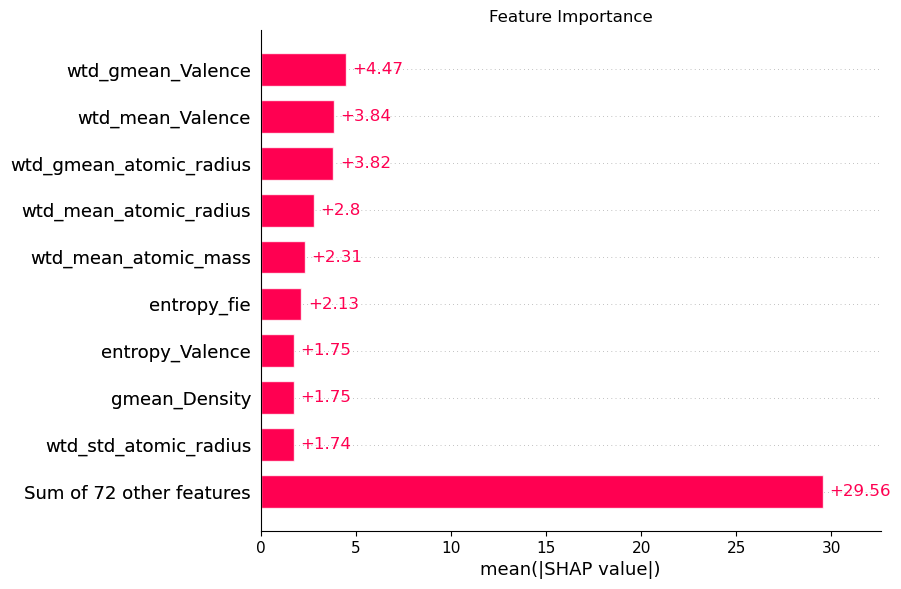

In [9]:
plt.title("Feature Importance")
#shap.summary_plot(shap_values, X_test_scaled, color="coolwarm")
shap.plots.bar(shap_values)
plt.show()

##### 📊 **Target distribution for GLM with clustering** 

For analysis the results in clustering for GLM, we can plot the target distribution for each group. For the that, it´s necessary to train the Birch with the params discovered by Optuna and the same data used in optimization process.

After that we can import the params of the Optuna best trial.

In [10]:
study_name = "optimization_clusters_glm_teste21_07_2025_16_46_28"
#storage_url = "sqlite:///../Optuna_files/optimization_glm_bayesian.db"
storage_url = "sqlite:///optimization_glm_bayesian.db"
study_glm = optuna.load_study(study_name=study_name, storage=storage_url)

In [11]:
study_glm.best_params

{'clusterer': 'birch',
 'n_clusters_birch': 10,
 'branching_factor': 700,
 'threshold': 0.18251719168858943,
 'distribution': 'gaussian',
 'link_gaussian': 'identity'}

The chosen clusterer was **Balanced Iterative Reducing and Clustering using Hierarchies (BIRCH)** . This type of clustering is used for numeric large datasets and its process can divided in two main steps:
* Clustering Feature (CF) tree, what is a compact representation of informations present in dense regions. In a CF, each entrance in a leaf vertex is a subcluster. 
* Global clusterization of the summaries.

And with that, train the chosen clusterer (Birch) with the chosen params.

In [12]:
birch_glm = Birch(n_clusters=10,
                    branching_factor=700,
                    threshold=0.18251719168858943)

In [13]:
cluster_labels = birch_glm.fit_predict(X_train)

unique_clusters = np.unique(cluster_labels)
valid_clusters = [c for c in unique_clusters if c != -1]

With that, we can visualize the target distributions for each cluster.

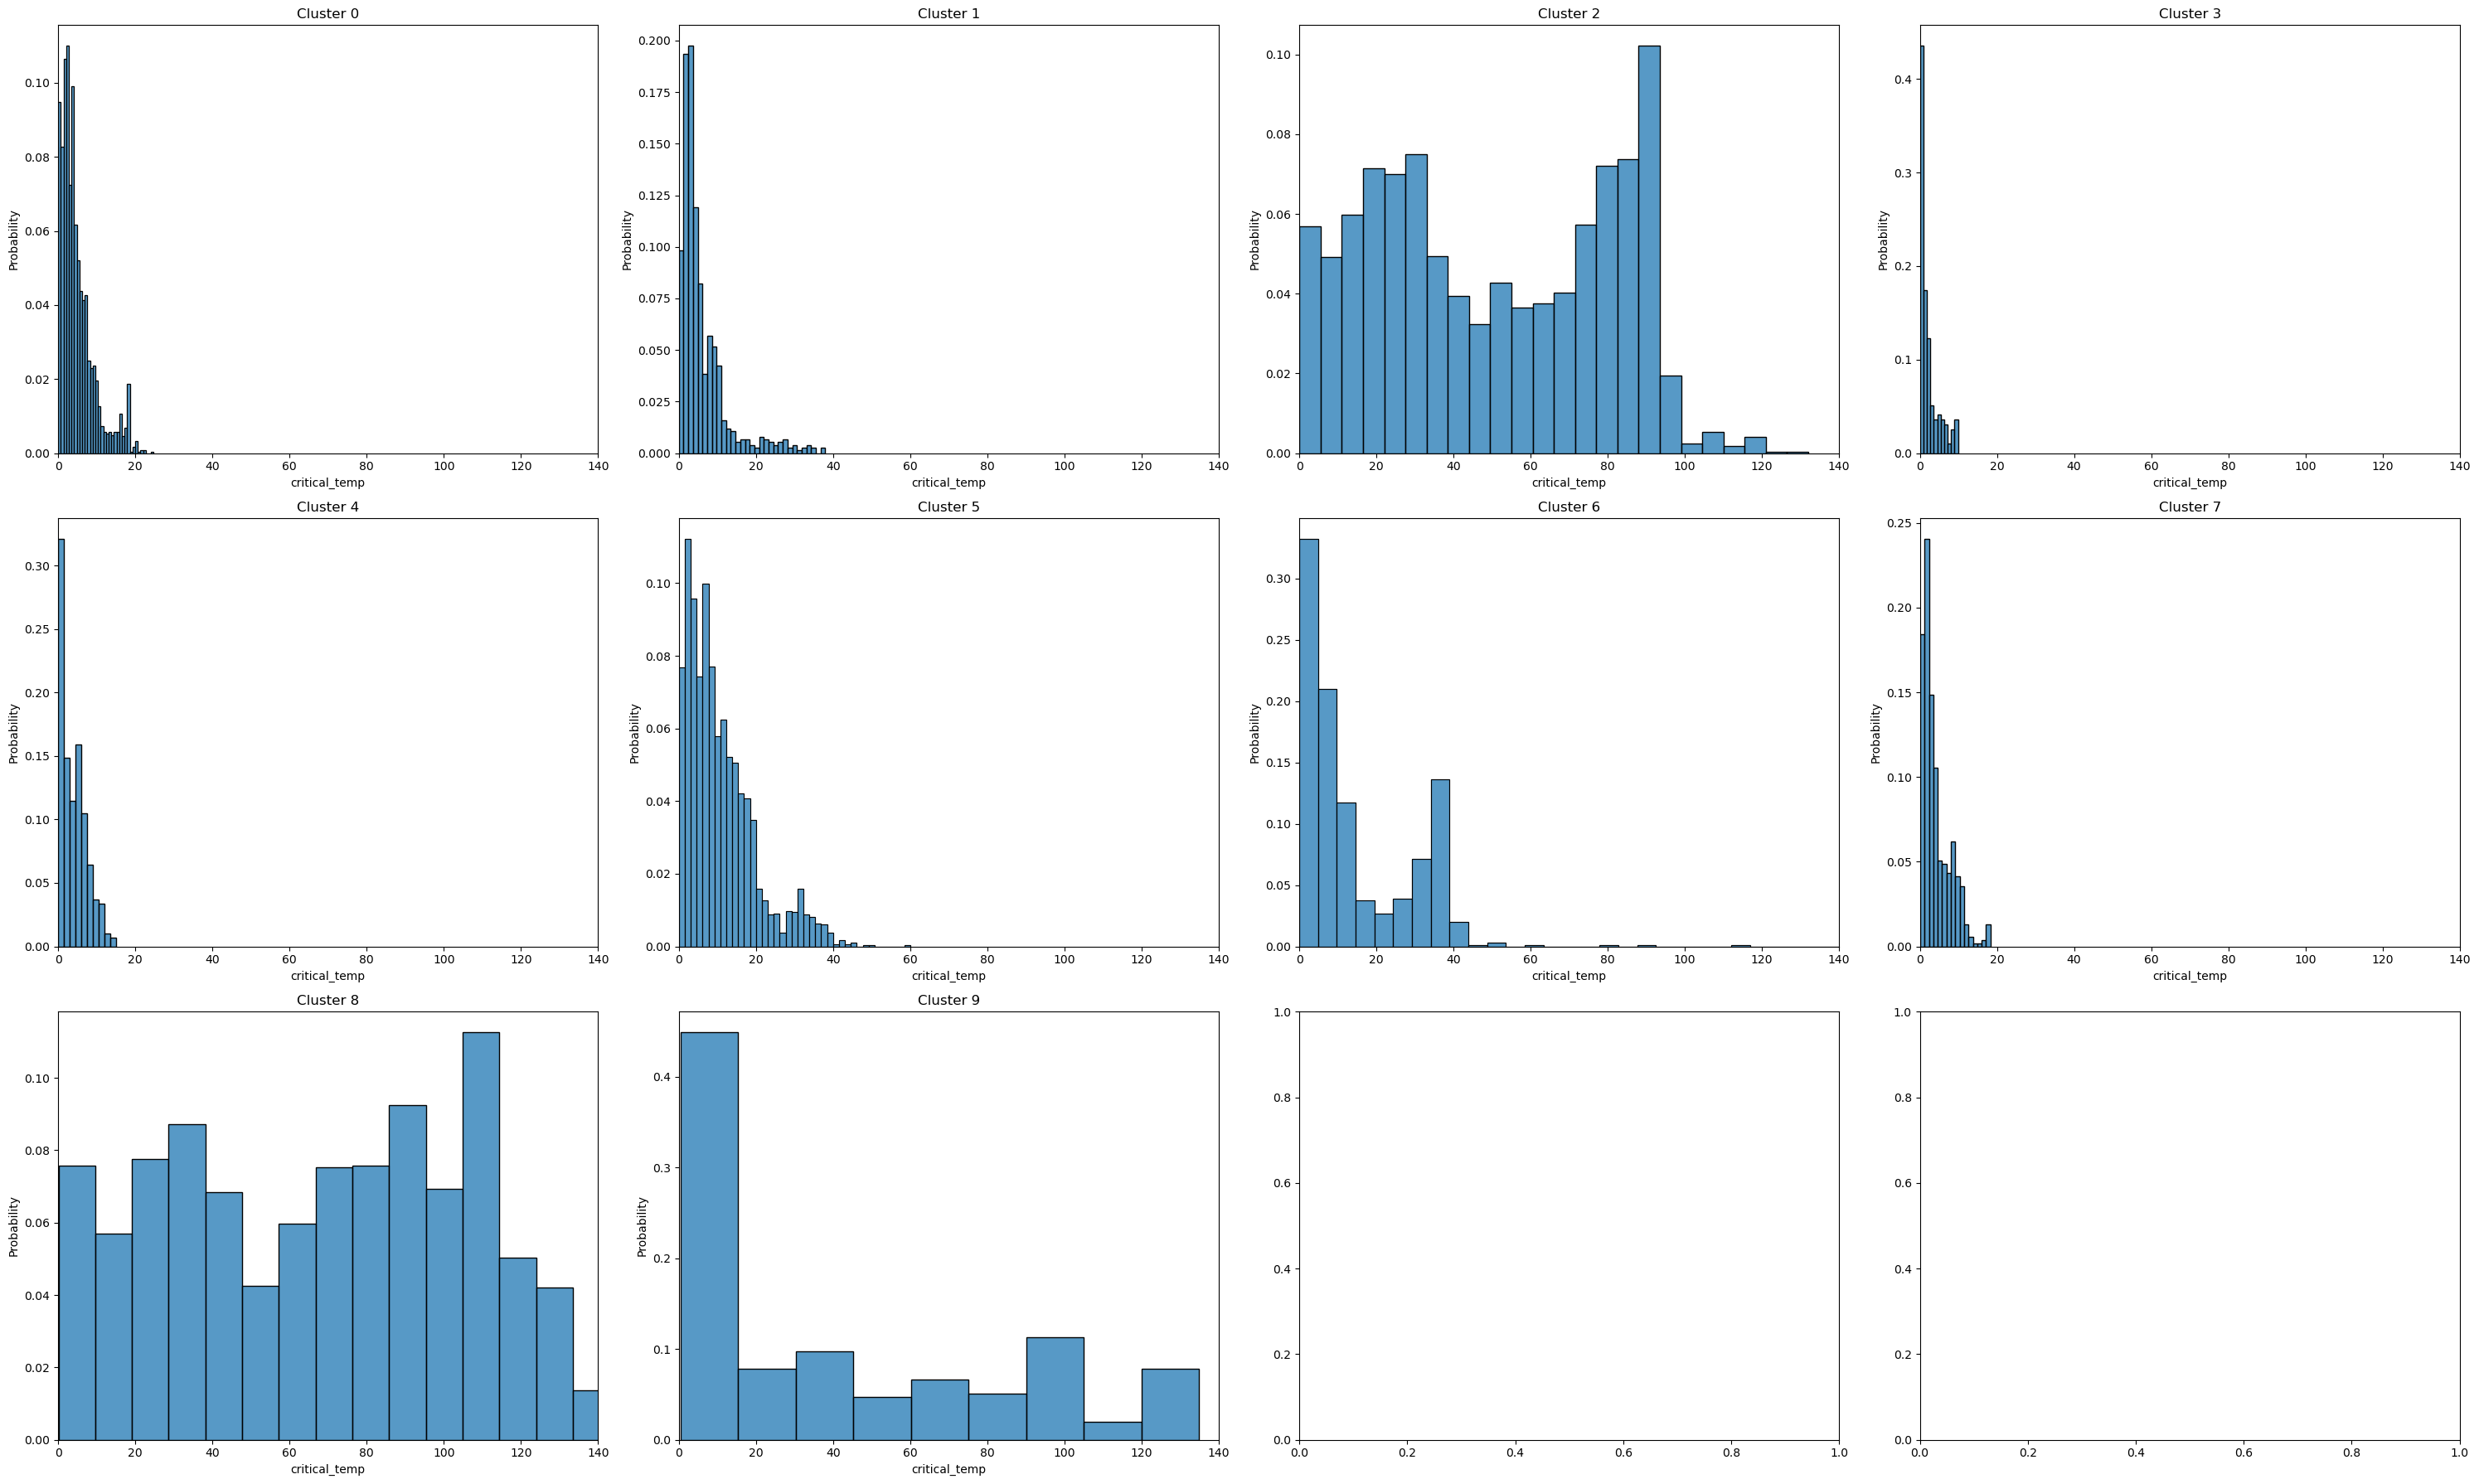

In [14]:
fig, axs = plt.subplots(3, 4, figsize=(30, 18))
axs = axs.flatten()

count = 0
for cluster in valid_clusters: 
    idx = np.where(cluster_labels == cluster)[0]

    X_cluster = X_train.iloc[idx]
    y_cluster = y_train.iloc[idx]

    sns.histplot(y_cluster, ax=axs[count], kde=False, stat="probability")  
    axs[count].set_title(f"Cluster {cluster}")
    axs[count].set_xlim(0, 140)

    count += 1
    if count >= len(X_train.columns): 
        break

plt.tight_layout()
plt.show()


Using the same X-axis interval for all the plots, it is clear that the distributions are very different. However, the ranges used are not well defined, so it is not possible to identify the clustering criteria based on this plot alone.

##### 🔎 **Interpretability and Explicability**

In clustering GLM case, the model coefficients, given the chosen distribution (Gaussian) and link function (identity), already indicate feature importance without any additional calculations, since this configuration corresponds to a standard Linear Regression.

In [15]:
import sys
sys.path.append('..//Main_Scripts')

from script_glm_interpretability import *

In [16]:
glm = Clustering_GLM(clusterer=clone(birch_glm),
                    distribution = sm.families.Gaussian(link=Identity())
    )

In [17]:
glm.fit(X_train, y_train, X_test)

Clustering_GLM(clusterer=Birch(branching_factor=700, n_clusters=10,
                               threshold=0.18251719168858943),
               distribution=<statsmodels.genmod.families.family.Gaussian object at 0x7fbb42180490>)

Let´s test!

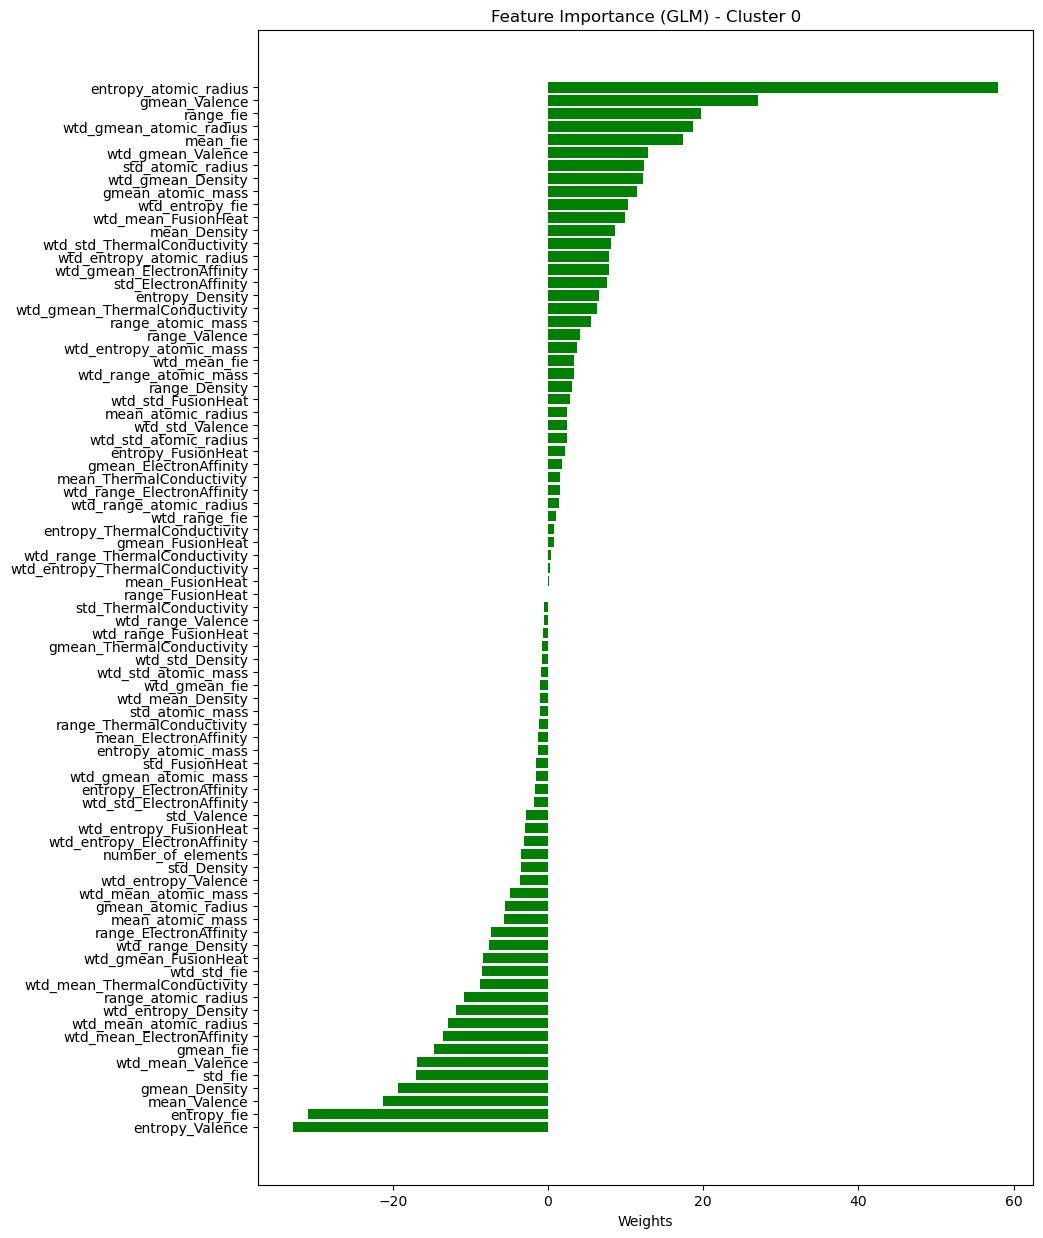

Feature  Feature Importance
25    entropy_atomic_radius           57.973256
75          entropy_Valence           32.801568
15              entropy_fie           30.955424
73            gmean_Valence           27.027919
71             mean_Valence           21.248236
17                range_fie           19.708954
33            gmean_Density           19.327632
24  wtd_gmean_atomic_radius           18.710692
11                 mean_fie           17.427048
19                  std_fie           16.962003

In [18]:
df_fi0 = glm.feature_importance(cluster=0, k=10)
display(df_fi0)

Here, we can visualize the weight of each feature within a cluster and identify the top-$k$ most important ones, defined by the absolute value of their weights.

We can do this now with the other clusters! By that, we can visualize the plots and, after that, make an histogram with the most frequent features, considering all the clusters. 

In [19]:
df_fi = df_fi0.copy()

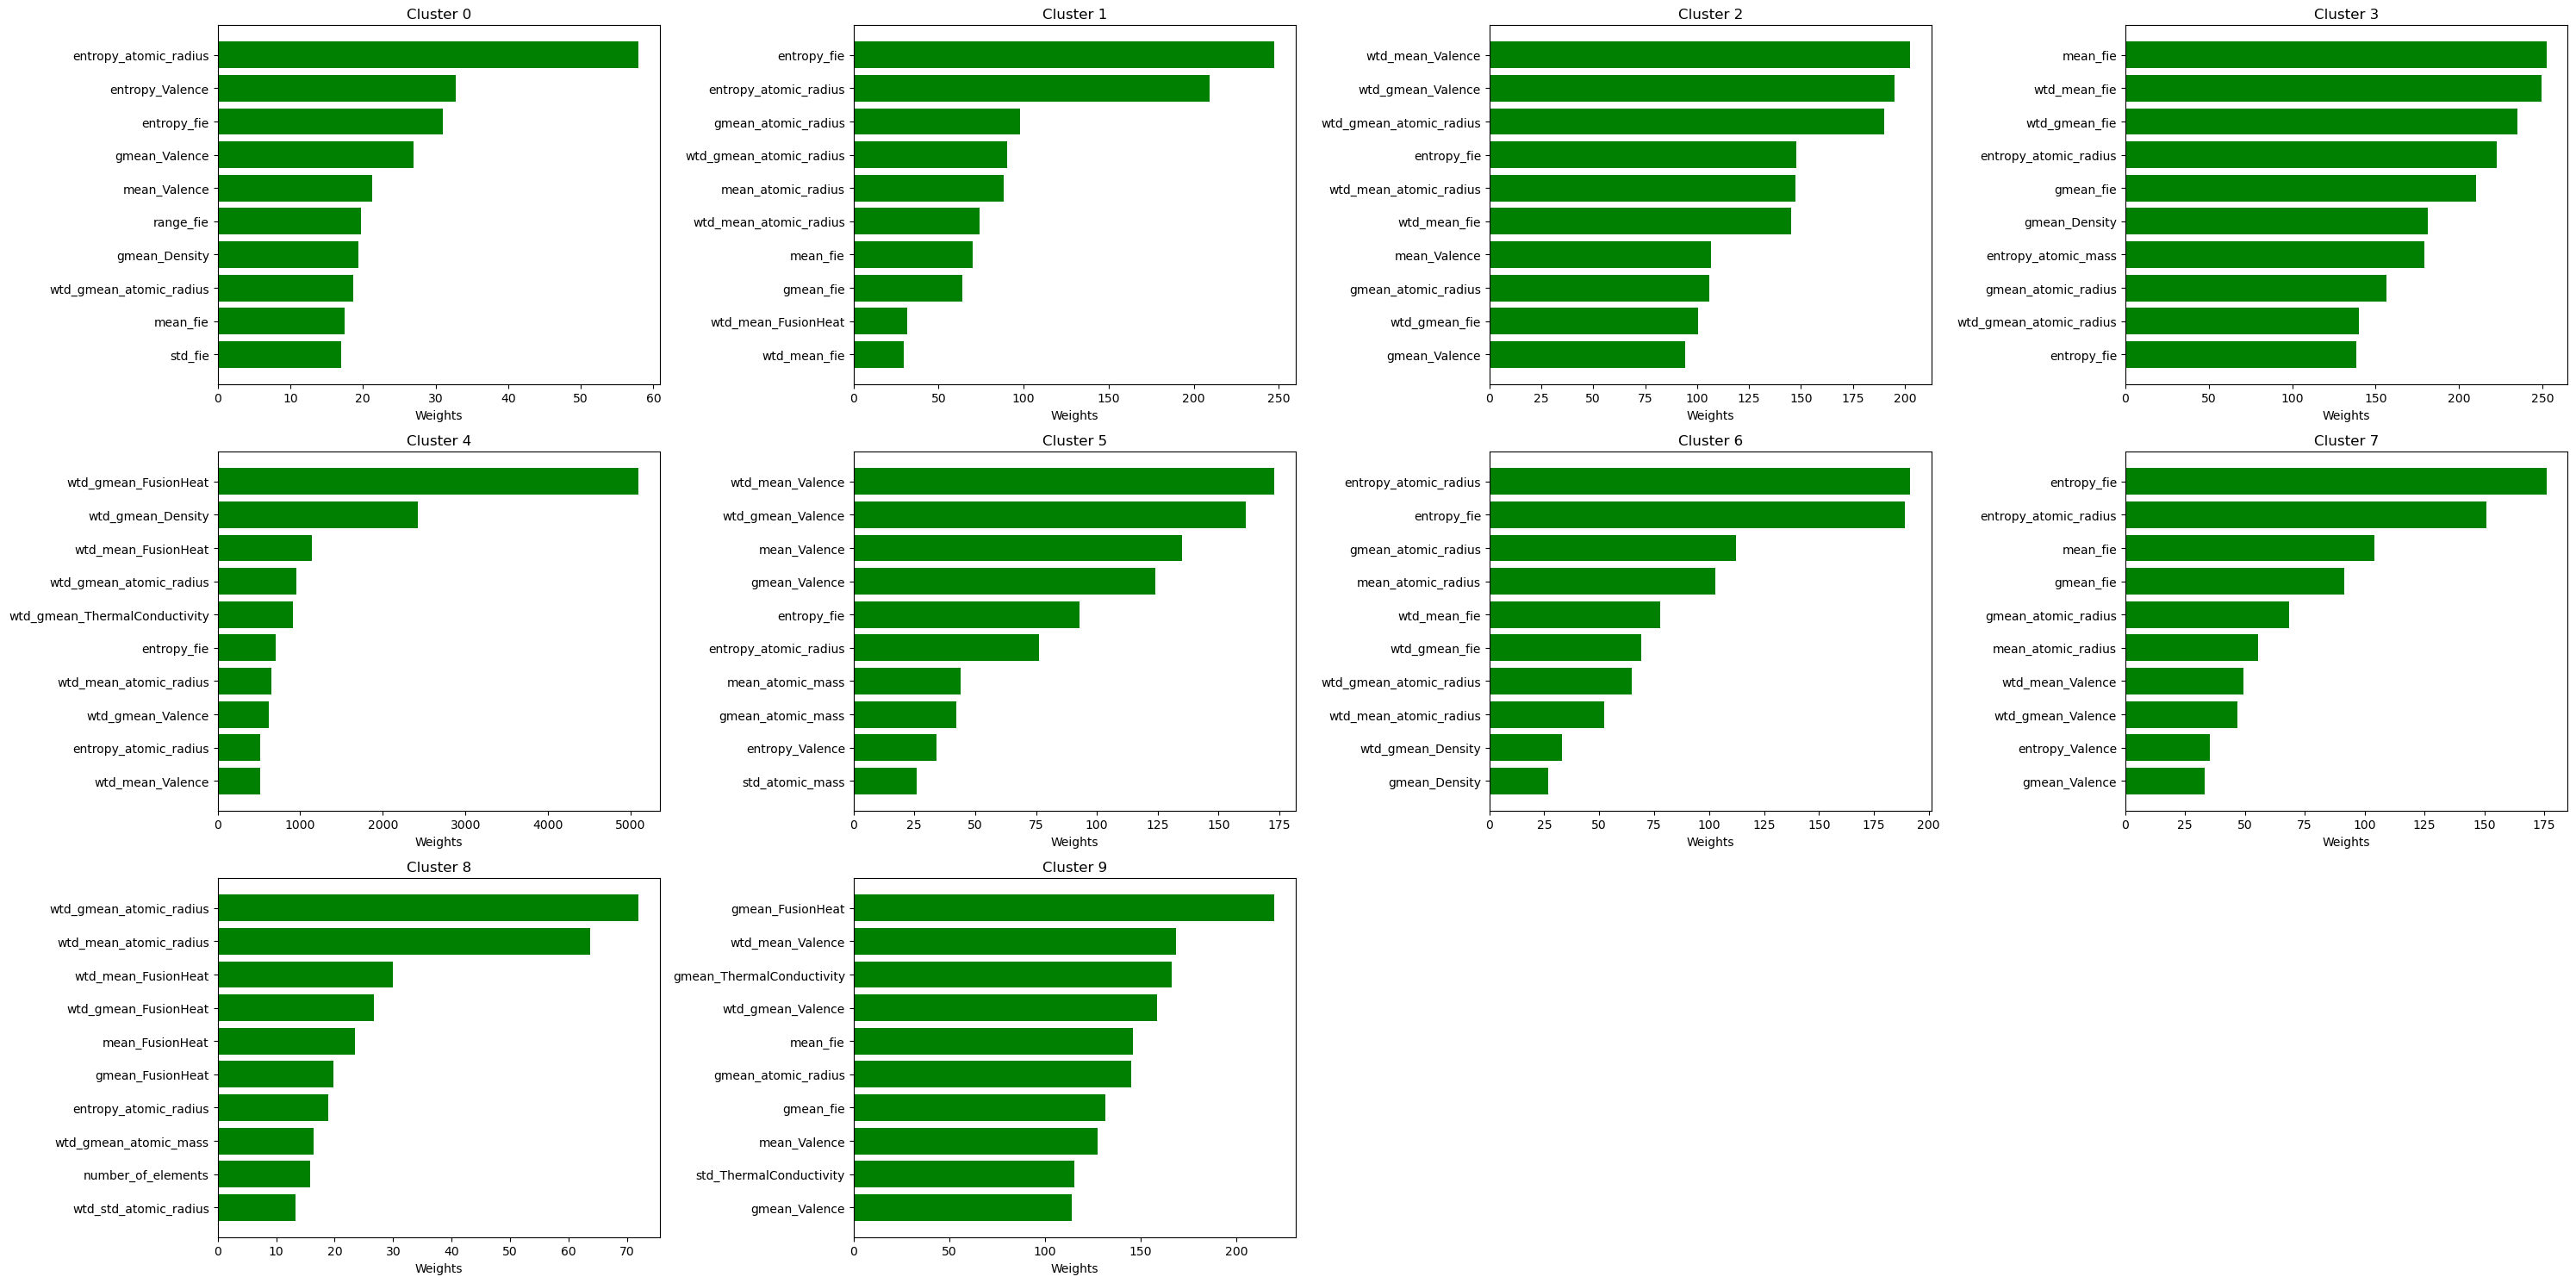

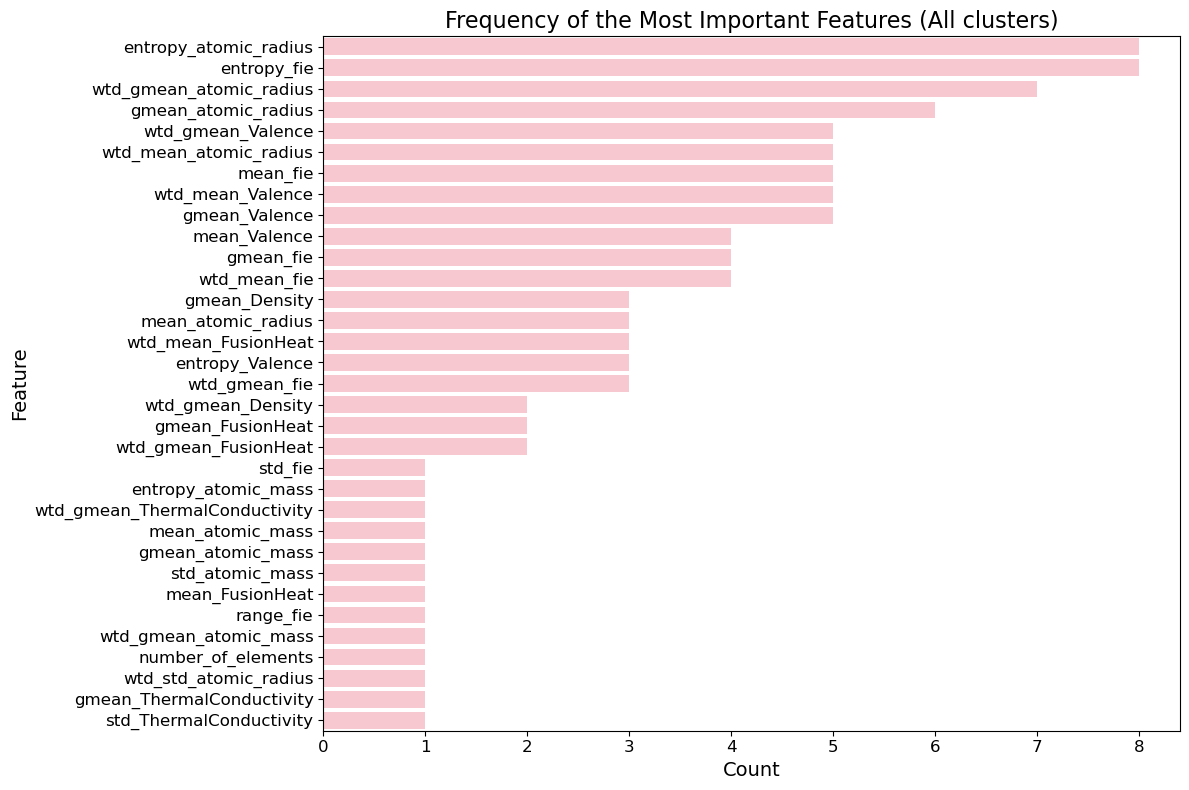

Feature  Feature Importance
0     entropy_atomic_radius           57.973256
1           entropy_Valence           32.801568
2               entropy_fie           30.955424
3             gmean_Valence           27.027919
4              mean_Valence           21.248236
..                      ...                 ...
95      gmean_atomic_radius          144.900781
96                gmean_fie          131.735995
97             mean_Valence          127.633430
98  std_ThermalConductivity          115.235376
99            gmean_Valence          113.830987

[100 rows x 2 columns]

In [20]:
glm.feature_importance_general()

It´s interesting to notice that the feature that was considered as the most important, in a expressive way, for the model with all instances (``range_Thermal_Conductivity``) was not considered as the most important feature for any of the clusters. And isn´t in top 10, at all!

A fature that appeared most frequently in the top 10 most important features was ``entropy_atomic_radius``, in 8 clusters.

We can verify the distribution of this feature for each cluster and compare with the distribution with all the features.

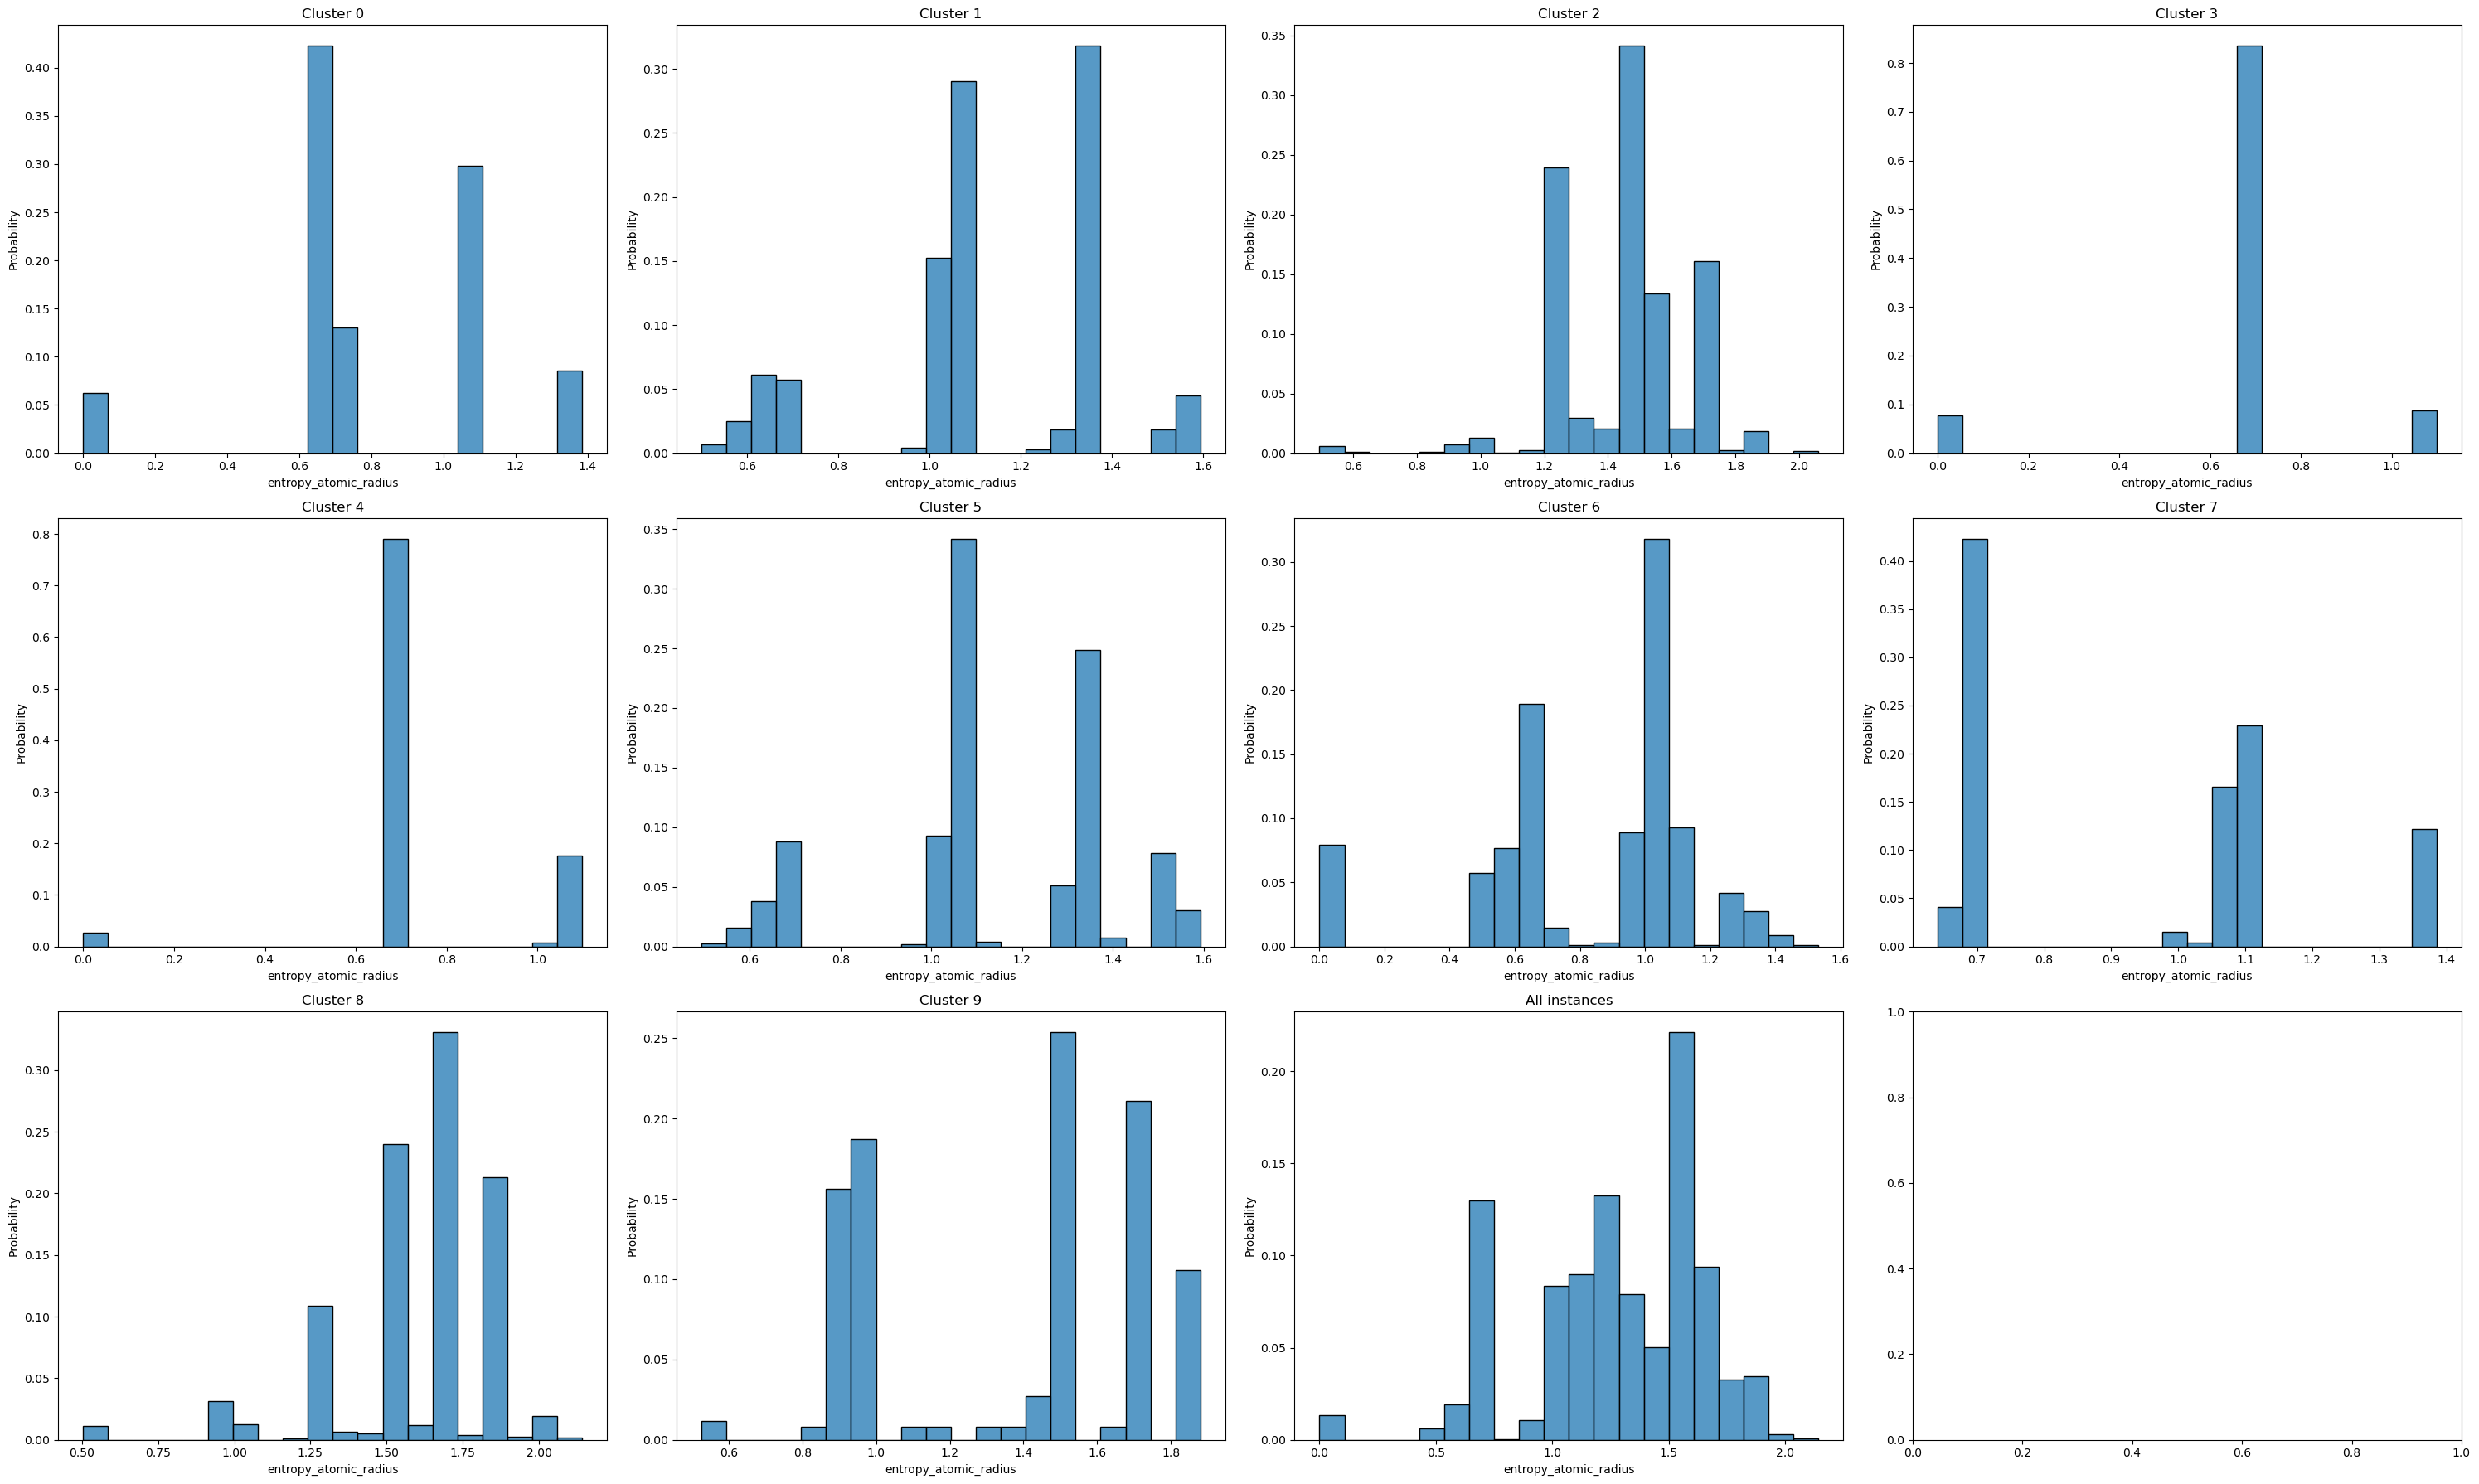

In [21]:
fig, axs = plt.subplots(3, 4, figsize=(30, 18))
axs = axs.flatten()

count = 0
for cluster in valid_clusters: 
    idx = np.where(cluster_labels == cluster)[0]

    X_cluster = X_train.iloc[idx]
    y_cluster = y_train.iloc[idx]

    sns.histplot(X_cluster["entropy_atomic_radius"], ax=axs[count], kde=False, stat="probability", bins=20)  
    axs[count].set_title(f"Cluster {cluster}")

    count += 1
    if count >= len(X_train.columns): 
        break

sns.histplot(X_train["entropy_atomic_radius"], ax=axs[10], kde=False, stat="probability", bins=20) 
axs[10].set_title("All instances")

plt.tight_layout()
plt.show()

It´s evident that the clusters distributions are very different (between the clusters and in comparation to the histogram with all the instances). However, only based on these that it´s not possible to conclude something about the clustering

Now, using the method "SHAP" of Clustering_GLM class, it´s possible to analyse the SHAP values for our clusters. Two types of plot can be used in this function: ``waterfall`` - for an overview considering all the instances - and ``summary_plot`` - for analyse an specific instance, mainly outliers. 

So, while we dont´t have a specific instance to analyse, let´s see the waterfall plot for each group. It´s important to notice that the function returns shap 

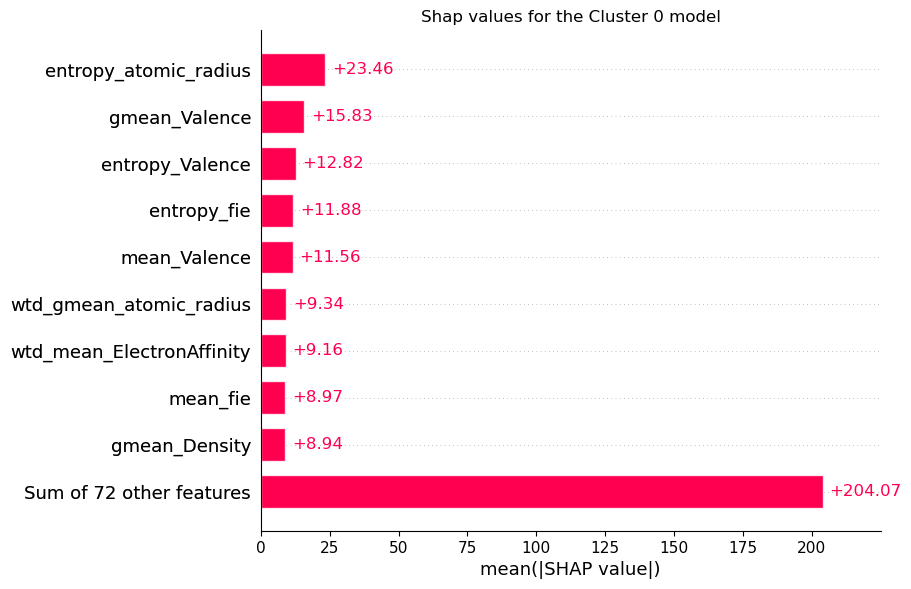

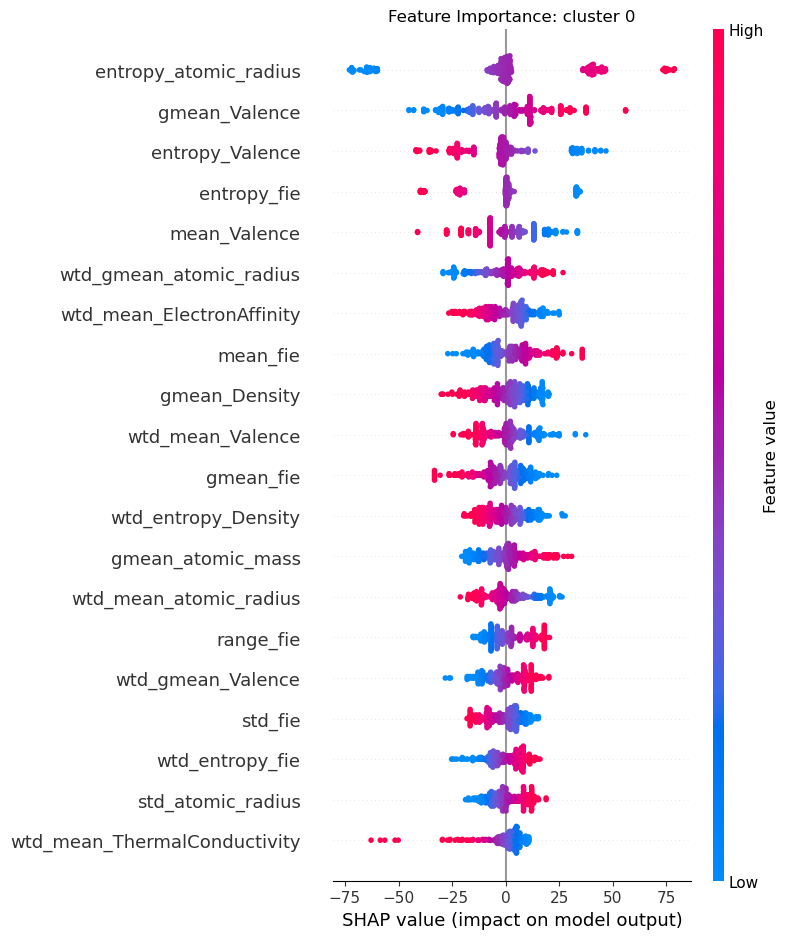

In [22]:
cluster_0_sv = glm.shap(cluster=0)

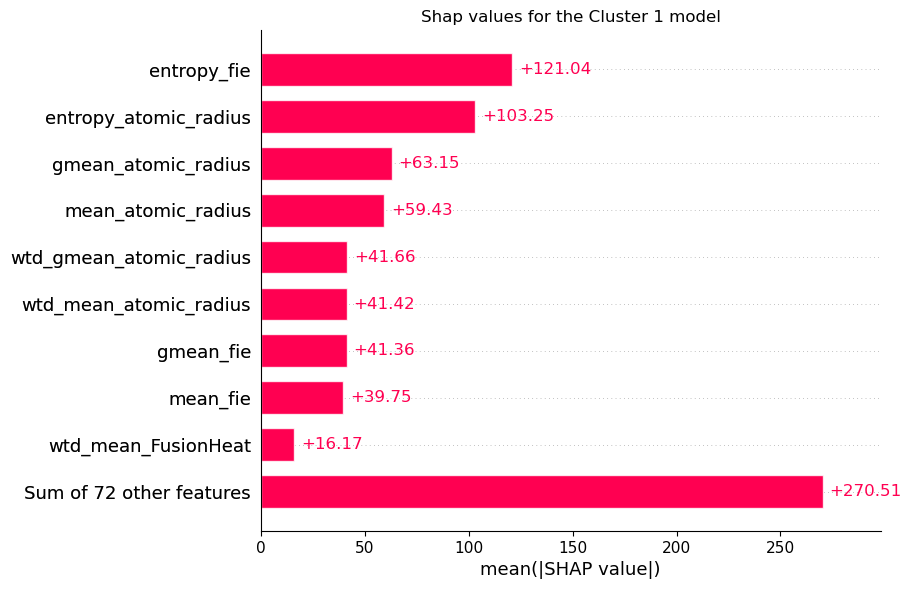

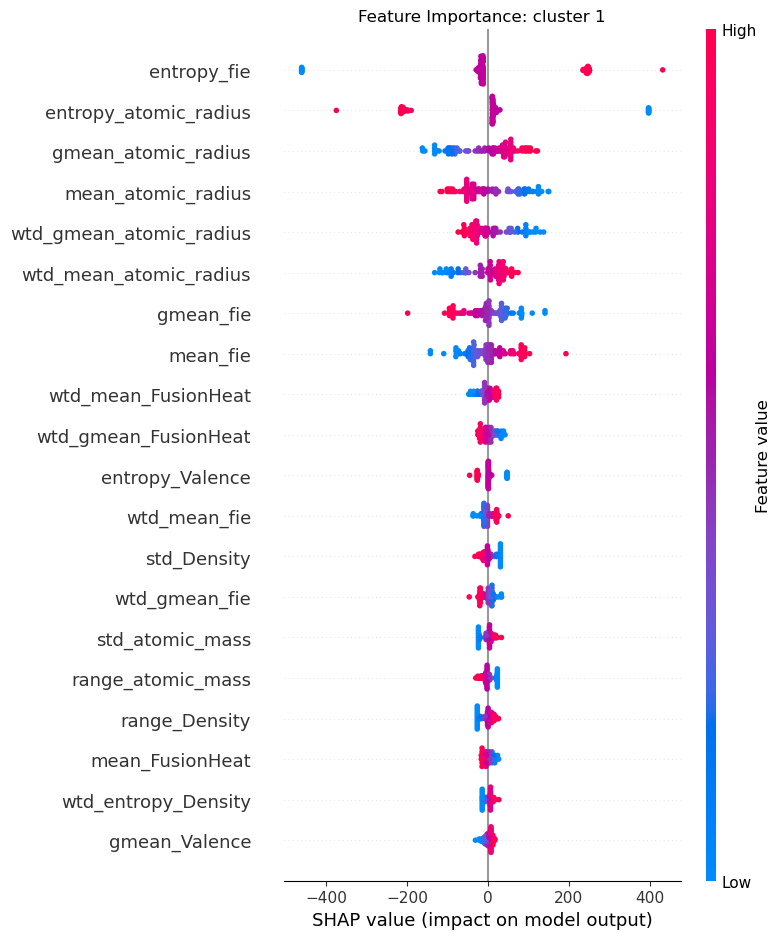

In [23]:
cluster_1_sv = glm.shap(cluster=1)

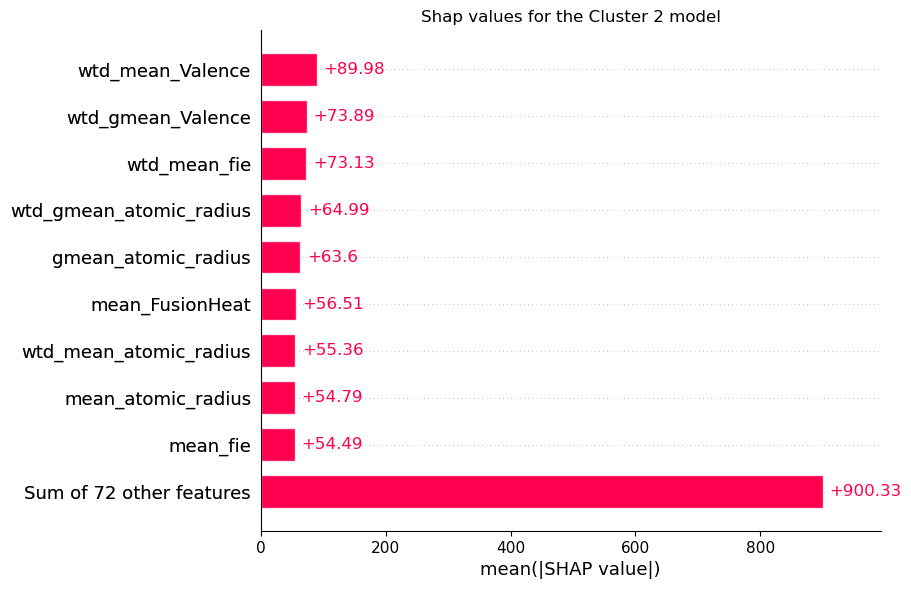

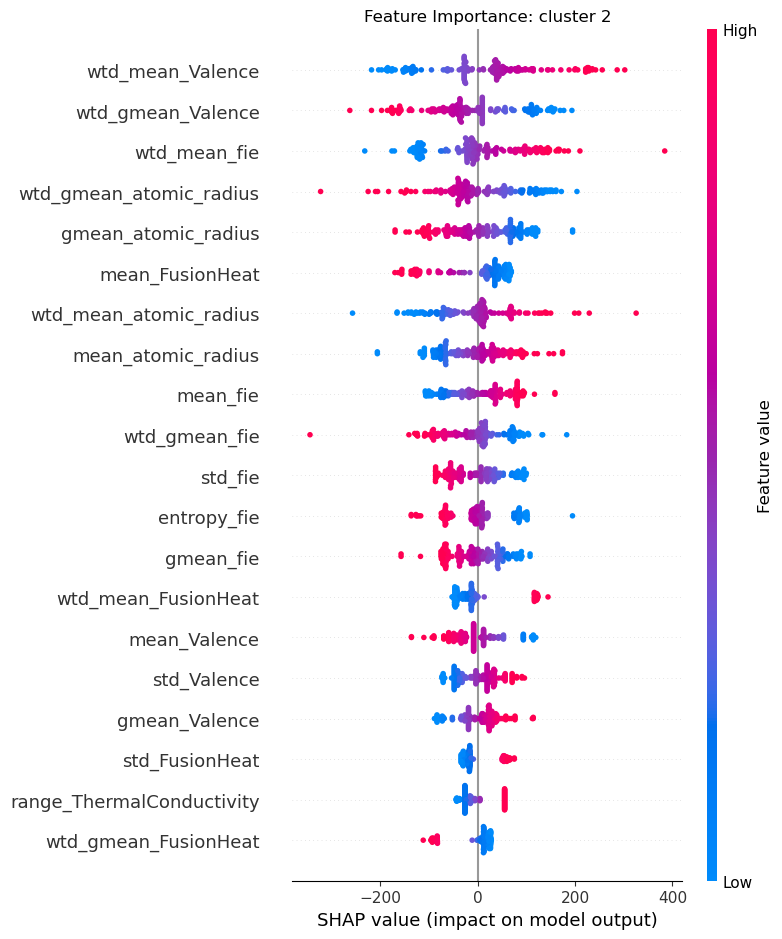

In [24]:
cluster_2_sv = glm.shap(cluster=2)

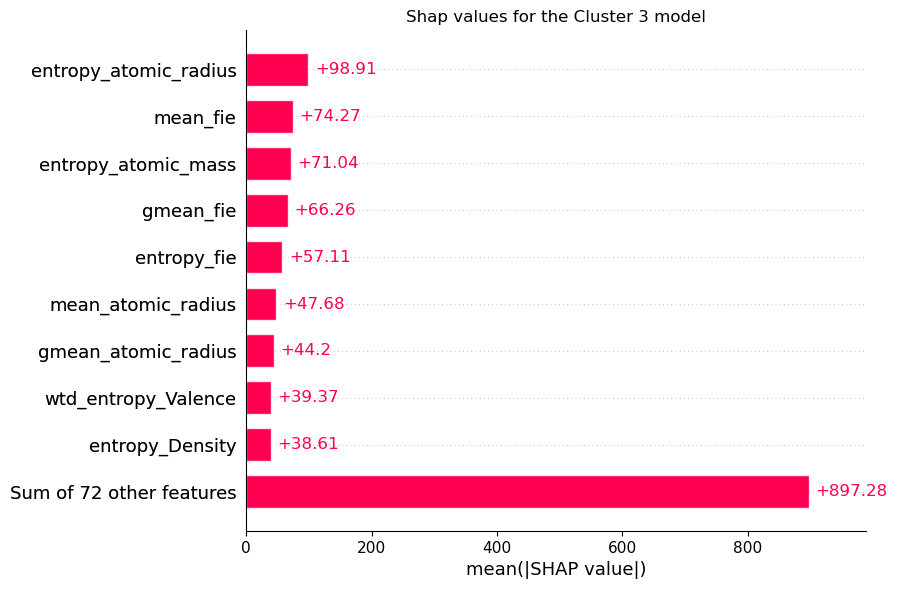

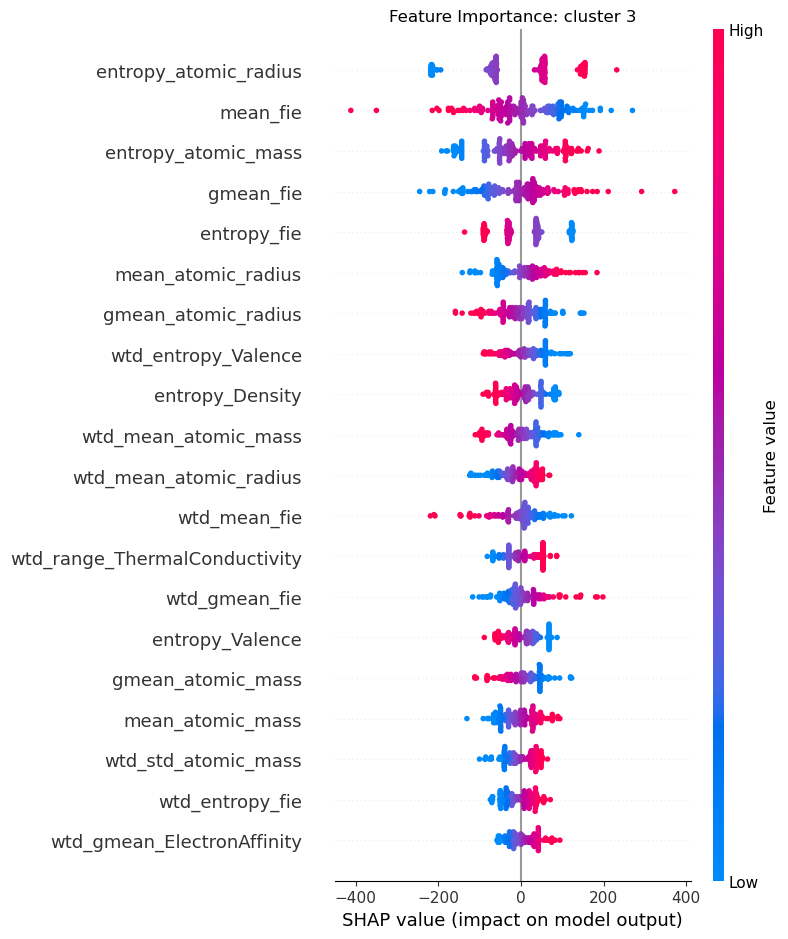

In [25]:
cluster_3_sv = glm.shap(cluster=3)

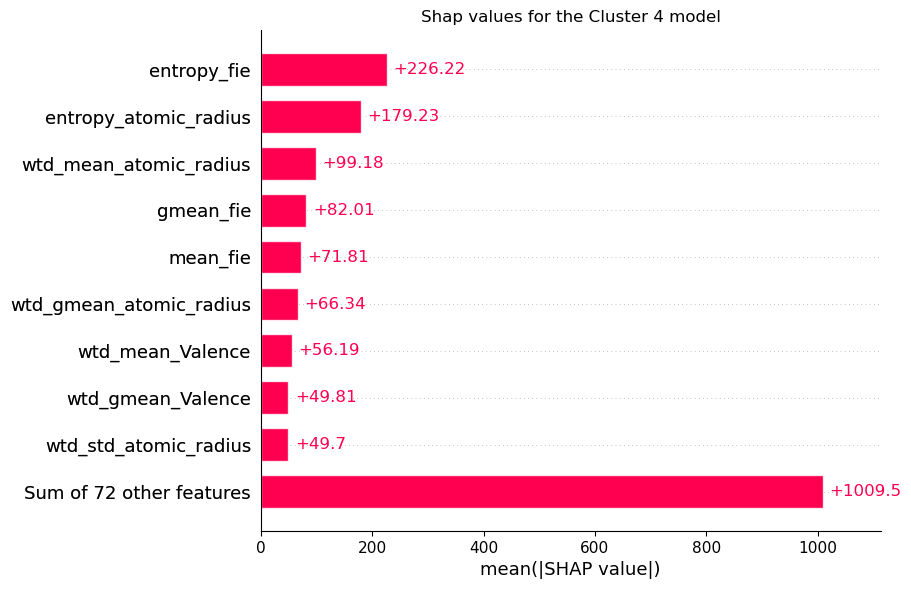

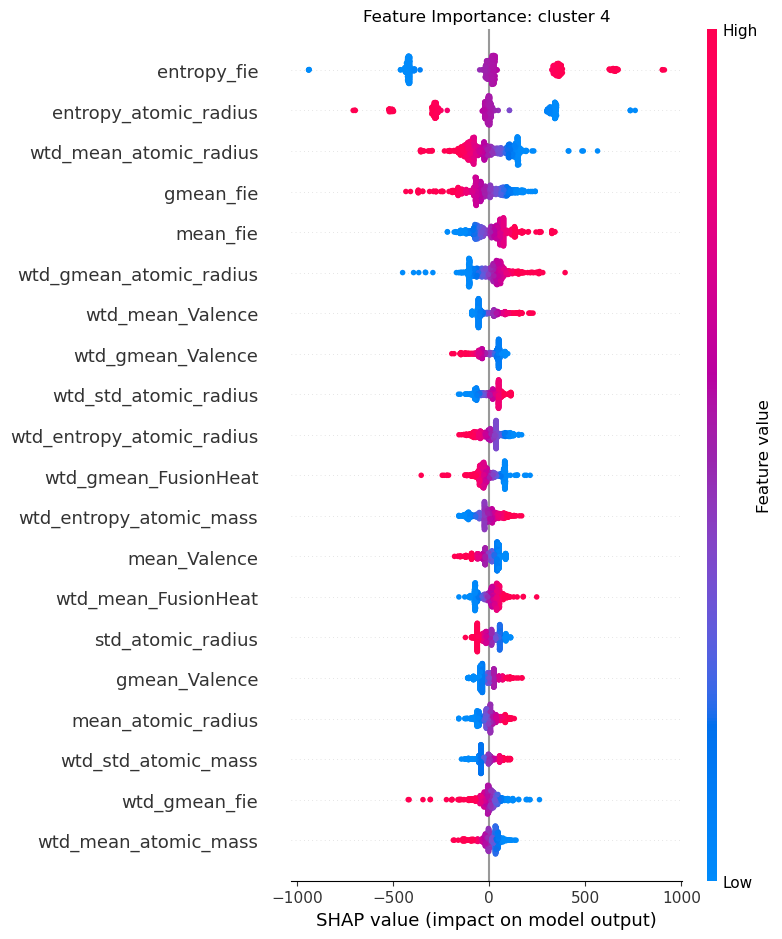

In [26]:
cluster_4_sv = glm.shap(cluster=4)

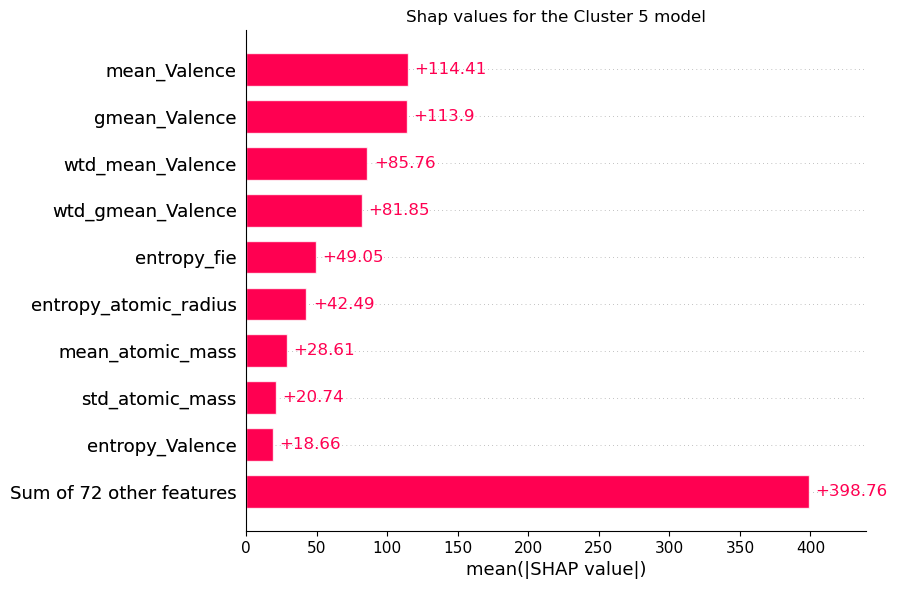

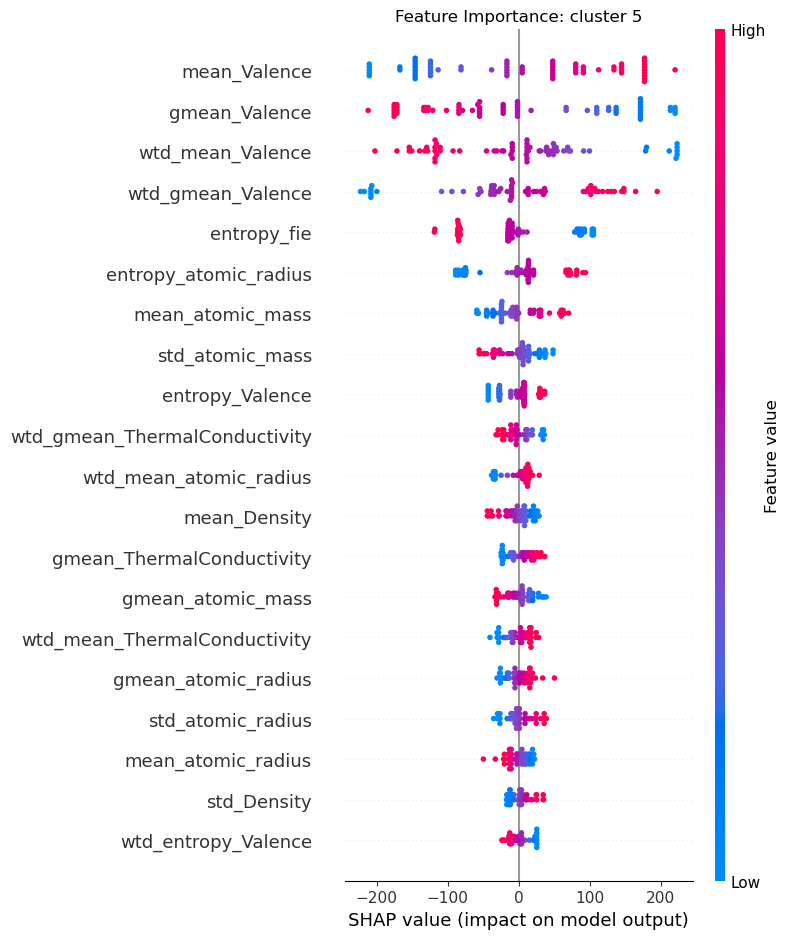

In [27]:
cluster_5_sv = glm.shap(cluster=5)

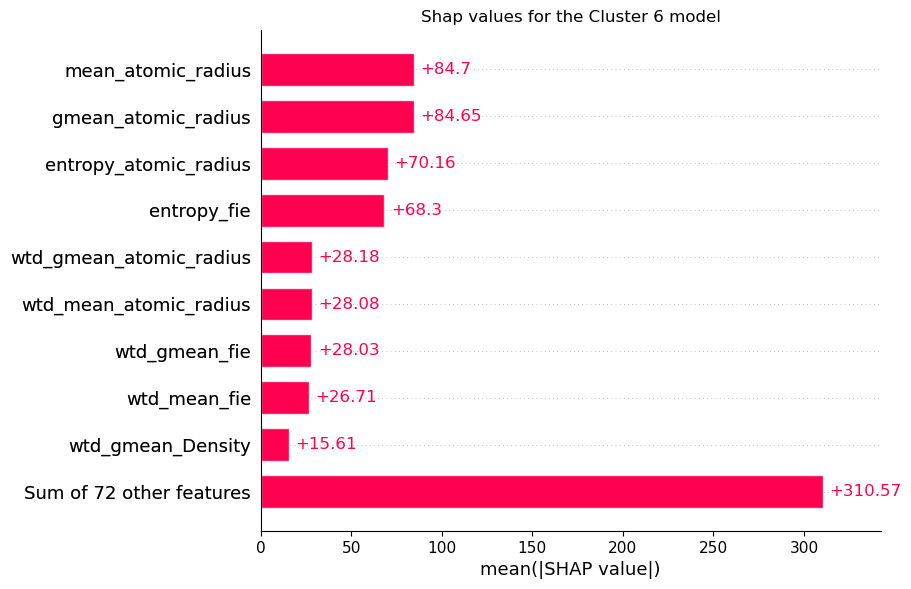

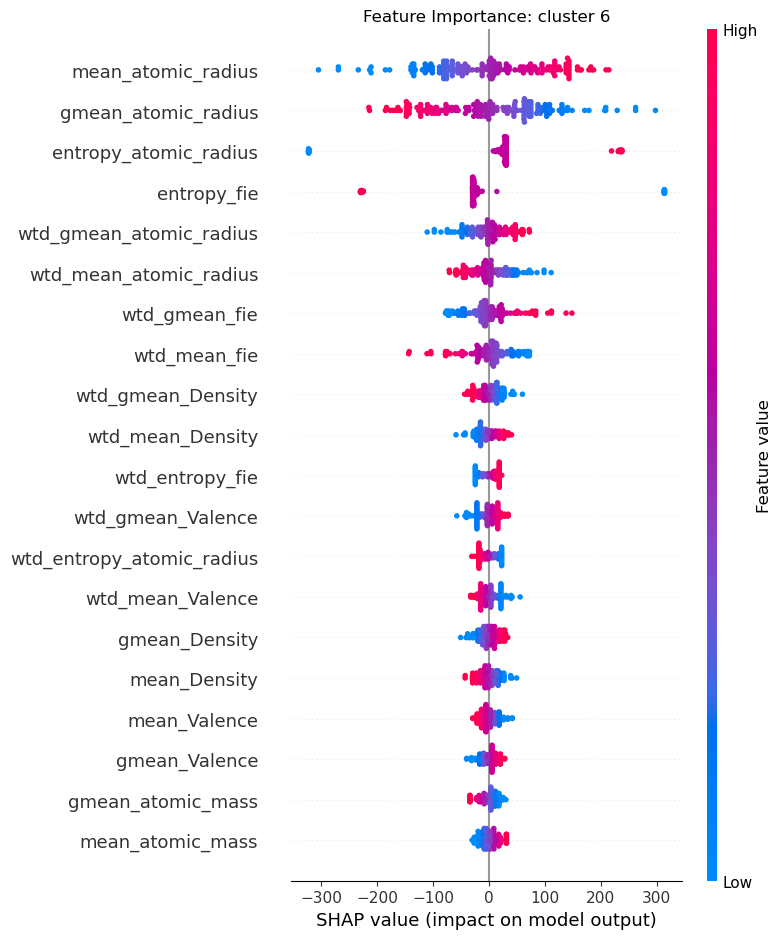

In [28]:
cluster_6_sv = glm.shap(cluster=6)

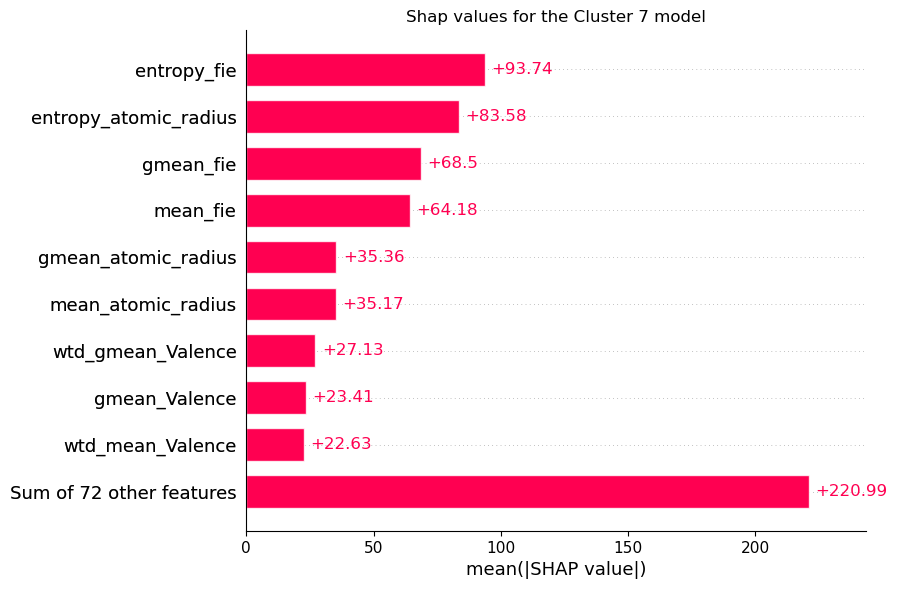

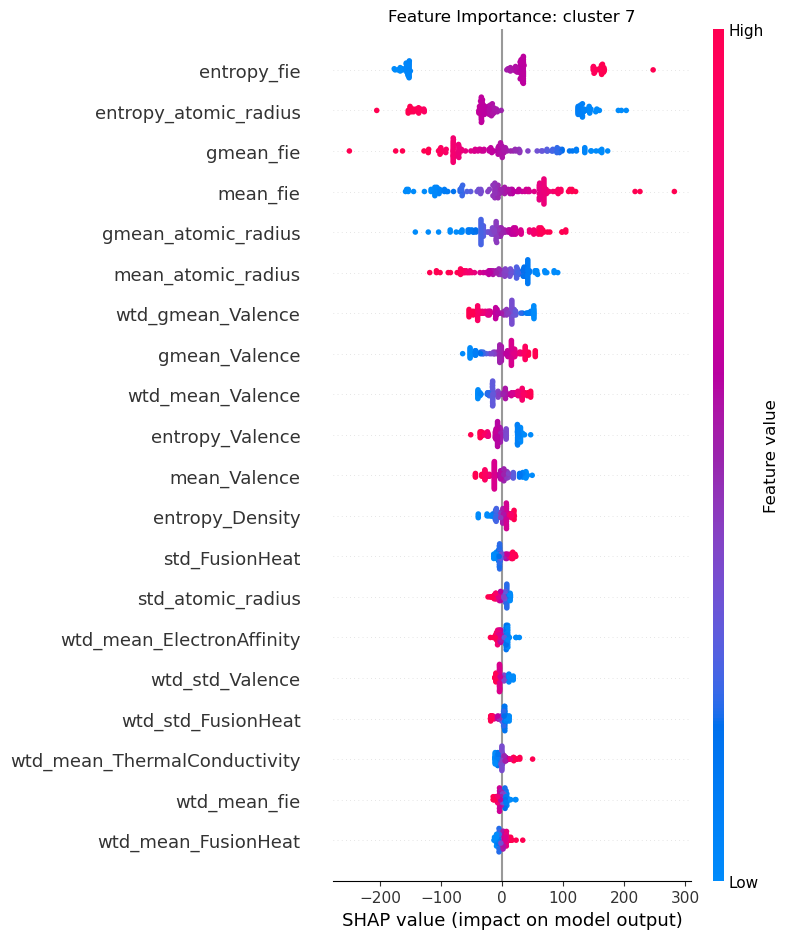

In [29]:
cluster_7_sv = glm.shap(cluster=7)

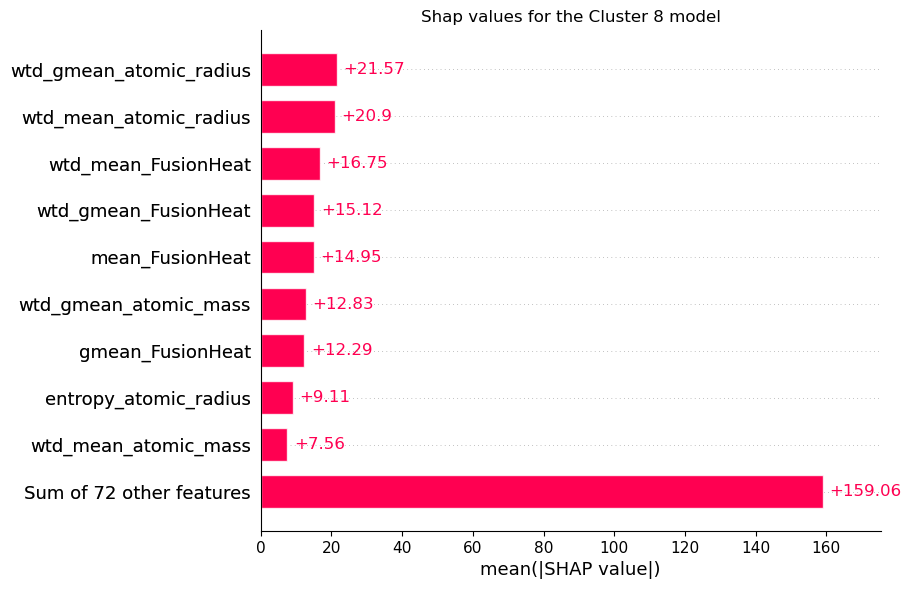

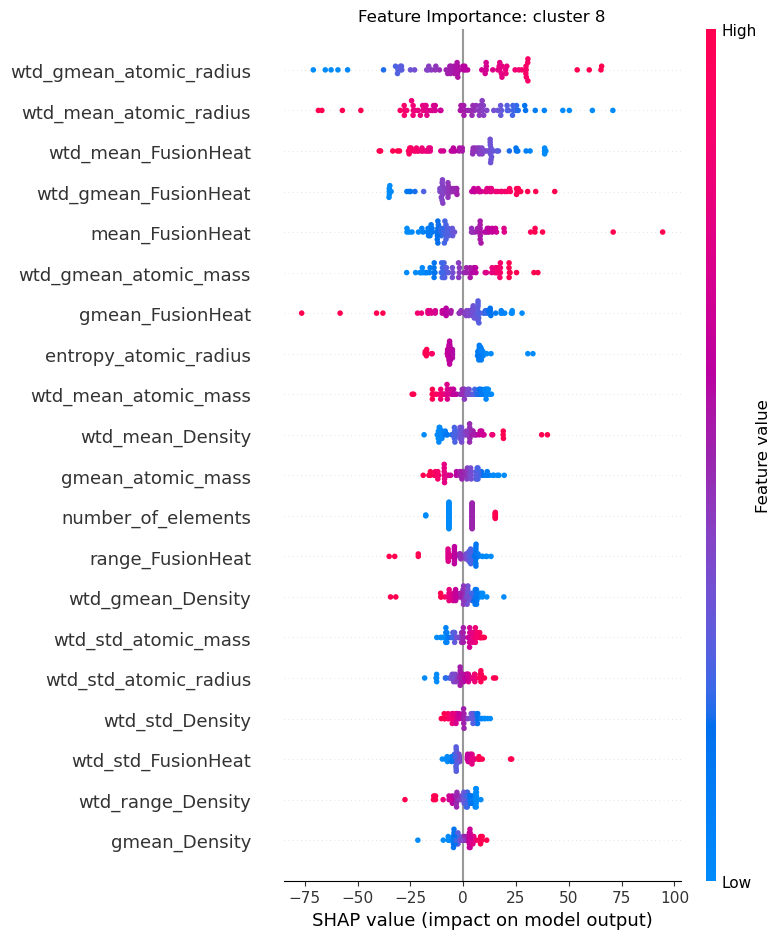

In [30]:
cluster_8_sv = glm.shap(cluster=8)

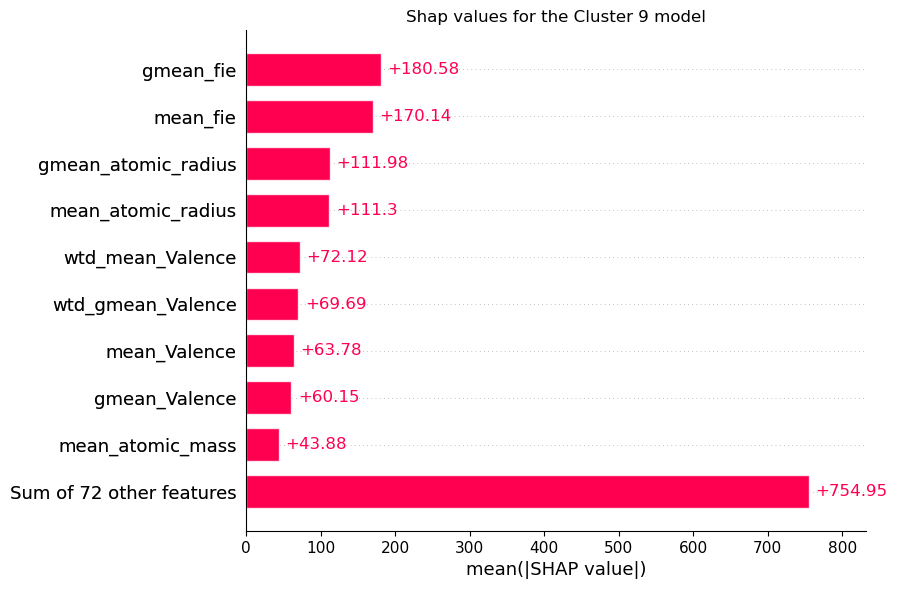

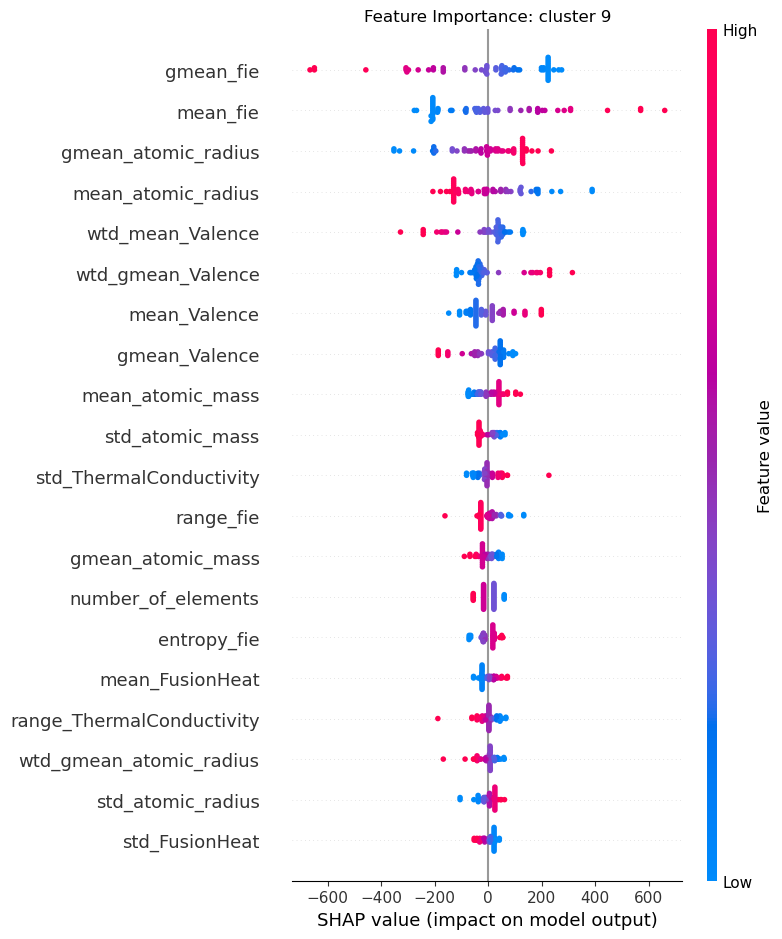

In [31]:
cluster_9_sv = glm.shap(cluster=9)

### **Generalized Additive Models (GAMs)**

##### 🔎 **Interpretability and Explicability**

The first step is to train a GAM on all instances, using the hyperparameters defined in the "Optimization and Hypothesis Testing" notebook.

In [32]:
terms = s(0)
        
for i in range(1, X_train.shape[1]):
    terms += s(i)
        
model_gam = pygam.pygam.GAM(terms, 
                            distribution="normal", 
                            link="identity", 
                            lam=0.2457079020965402, 
                            n_splines=20)
    
model_gam.fit(X_train_scaled, y_train)

GAM(callbacks=[Deviance(), Diffs()], distribution=NormalDist(), 
   fit_intercept=True, link=IdentityLink(), max_iter=100, 
   terms=s(0) + s(1) + s(2) + s(3) + s(4) + s(5) + s(6) + s(7) + s(8) + s(9) + s(10) + s(11) + s(12) + s(13) + s(14) + s(15) + s(16) + s(17) + s(18) + s(19) + s(20) + s(21) + s(22) + s(23) + s(24) + s(25) + s(26) + s(27) + s(28) + s(29) + s(30) + s(31) + s(32) + s(33) + s(34) + s(35) + s(36) + s(37) + s(38) + s(39) + s(40) + s(41) + s(42) + s(43) + s(44) + s(45) + s(46) + s(47) + s(48) + s(49) + s(50) + s(51) + s(52) + s(53) + s(54) + s(55) + s(56) + s(57) + s(58) + s(59) + s(60) + s(61) + s(62) + s(63) + s(64) + s(65) + s(66) + s(67) + s(68) + s(69) + s(70) + s(71) + s(72) + s(73) + s(74) + s(75) + s(76) + s(77) + s(78) + s(79) + s(80) + intercept,
   tol=0.0001, verbose=False)

Now, we can use the same explicability strategy (SHAP) for GAM without clustering. 

In [33]:
explainer = shap.Explainer(model_gam.predict, X_test_scaled)
shap_values = explainer(X_test_scaled)

PermutationExplainer explainer: 2128it [1:59:15,  3.37s/it]                            


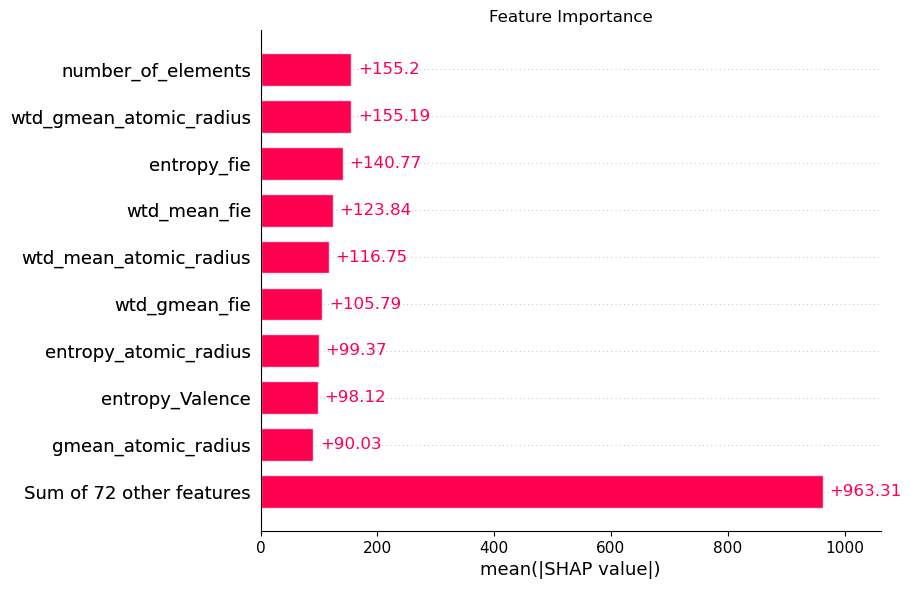

In [34]:
plt.title("Feature Importance")
#shap.summary_plot(shap_values, X_test_scaled, color="coolwarm")
shap.plots.bar(shap_values)
plt.show()

##### 📊 **Target distribution for GAM with clustering** 

In [35]:
import sys
sys.path.append('..//Main_Scripts')

from script_gam_interpretability import *

In [36]:
study_name = "optimization_clusters_gam_teste21_07_2025_16_52_45"
#storage_url = "sqlite:///../Optuna_files/optimization_glm_bayesian.db"
storage_url = "sqlite:///optimization_gam_bayesian.db"
study_gam = optuna.load_study(study_name=study_name, storage=storage_url)

In [37]:
study_gam.best_params

{'clusterer': 'bisecting_kmeans',
 'n_clusters_bkmeans': 24,
 'bisecting_strategy': 'largest_cluster',
 'distribution': 'normal',
 'link_gaussian': 'identity',
 'lam': 0.2457079020965402,
 'n_splines': 20}

The chosen clusterer was bisecting k-means with 24 groups. This algorithm is an iterative variant of k-means that uses a hierarchical division of clusters, based on a previous clustering to decide the centroids.

In [38]:
bkmeans_gam = BisectingKMeans(n_clusters=24,
                            bisecting_strategy="largest_cluster")

In [39]:
cluster_labels = bkmeans_gam.fit_predict(X_train)

unique_clusters = np.unique(cluster_labels)
valid_clusters = [c for c in unique_clusters if c != -1]

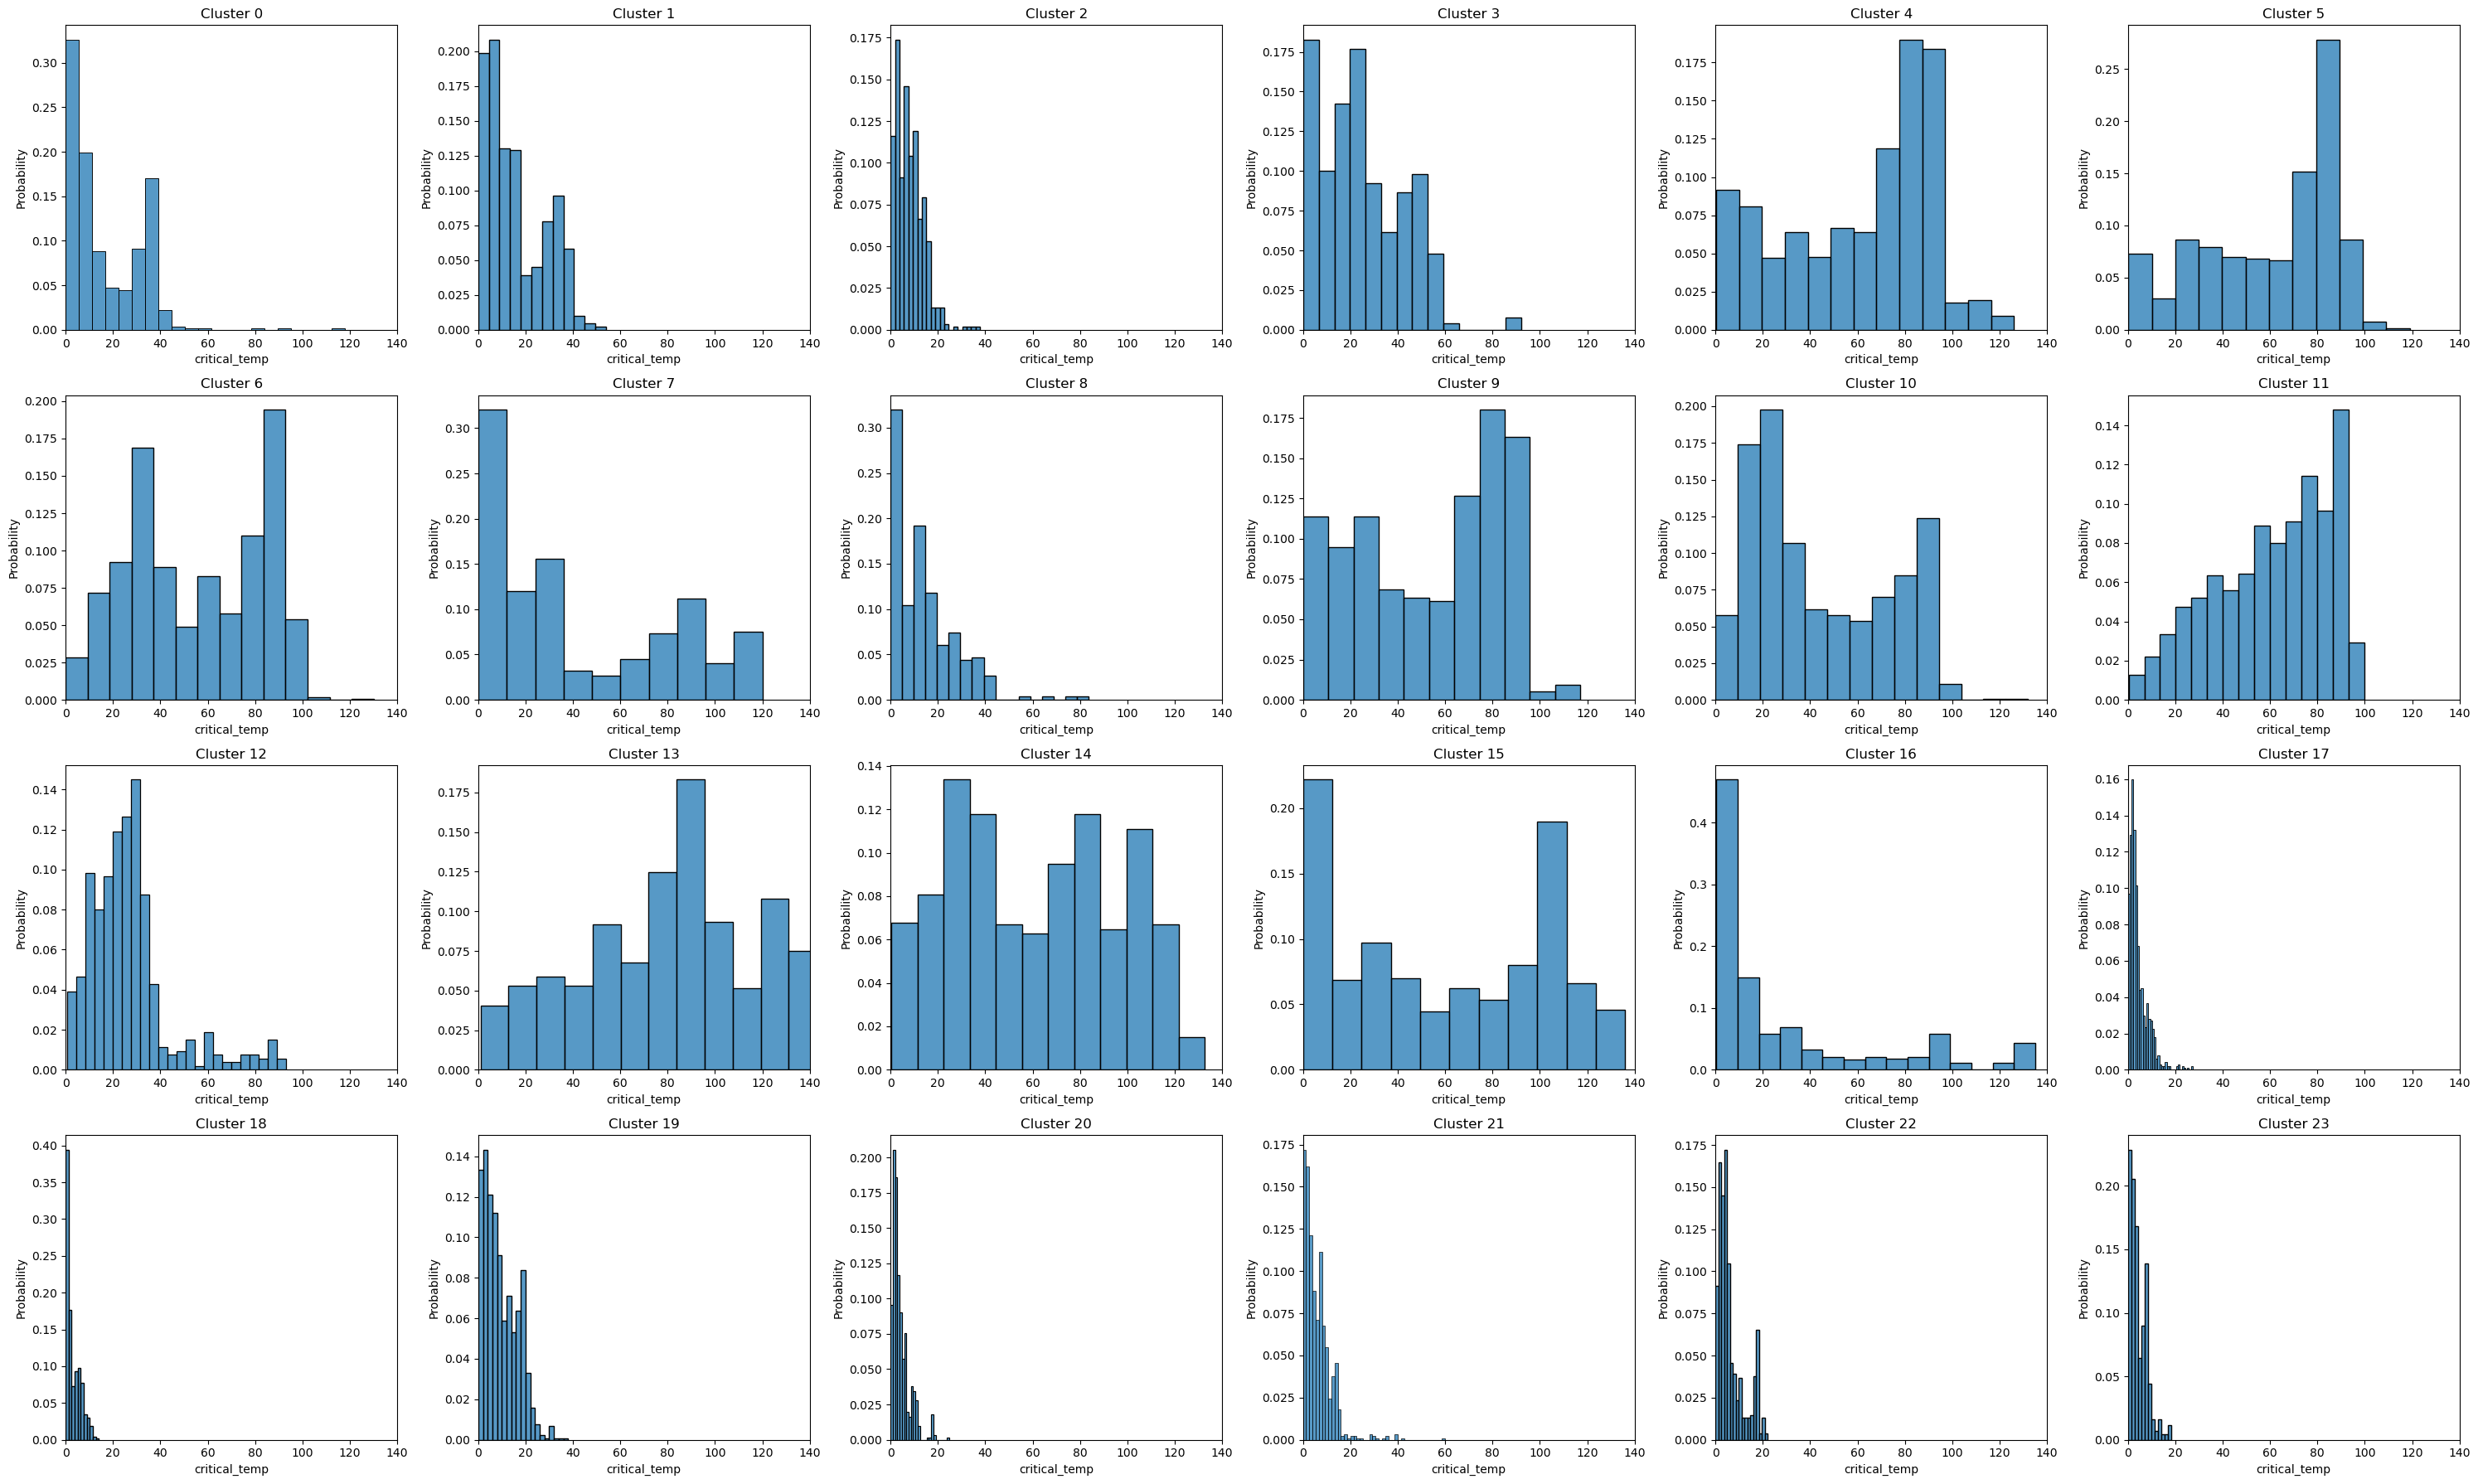

In [40]:
fig, axs = plt.subplots(4, 6, figsize=(30, 18))
axs = axs.flatten()

count = 0
for cluster in valid_clusters: 
    idx = np.where(cluster_labels == cluster)[0]

    X_cluster = X_train.iloc[idx]
    y_cluster = y_train.iloc[idx]

    sns.histplot(y_cluster, ax=axs[count], kde=False, stat="probability")  
    axs[count].set_title(f"Cluster {cluster}")
    axs[count].set_xlim(0, 140)

    count += 1
    if count >= len(X_train.columns): 
        break

plt.tight_layout()
plt.show()

As in the GLM case, the groups are very different from each other. However, it is possible to notice a pattern: the majority of clusters showed an exponential trend, similar to the original data. The clusters that covered a wider range of critical temperatures did not show any clear pattern.

In [41]:
gam = Clustering_GAM(clusterer=clone(bkmeans_gam),
                    distribution = "normal",
                    link="identity",
                    n_splines=20,
                    lam=0.2457079020965402)

In [42]:
gam.fit(X_train, y_train, X_test)

Clustering_GAM(clusterer=BisectingKMeans(bisecting_strategy='largest_cluster',
                                         n_clusters=24),
               distribution='normal', lam=0.2457079020965402, link='identity',
               n_splines=20)

So let´s test with one cluster!

PermutationExplainer explainer: 1278it [1:06:19,  3.12s/it]                          


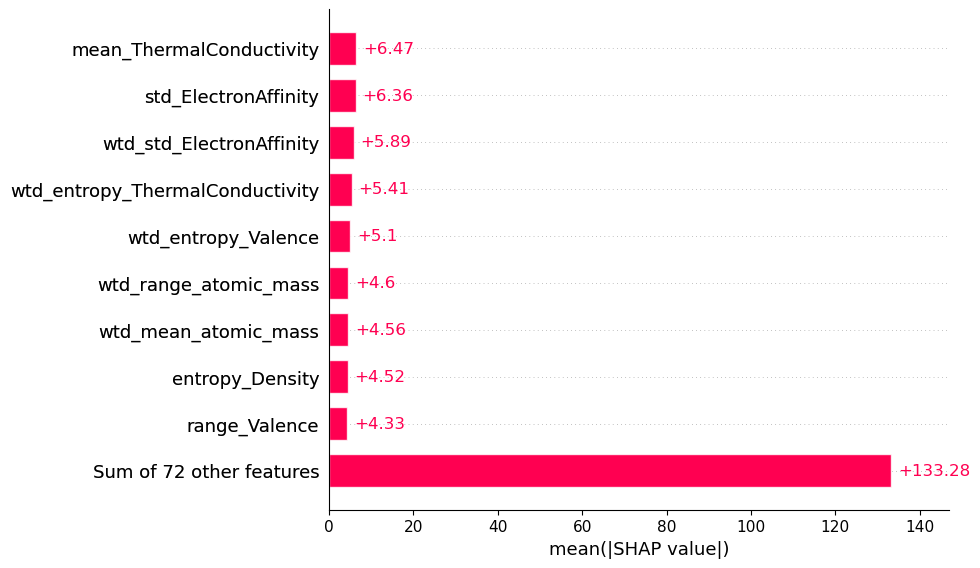

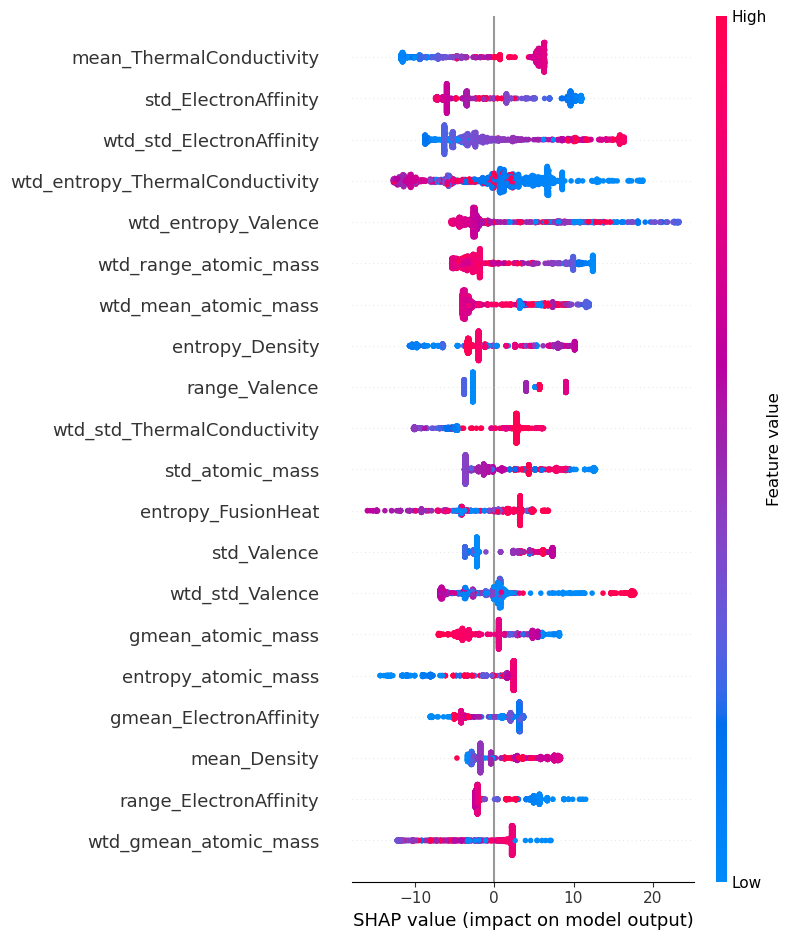

In [43]:
cluster_0_sv = gam.shap(cluster=0)

In addition, we can use a tool available in the pygam module to create a partial dependence plot for each cluster. This type of plot identifies the relationship between the feature and the target, or more specifically, how variations in the feature affect the prediction.

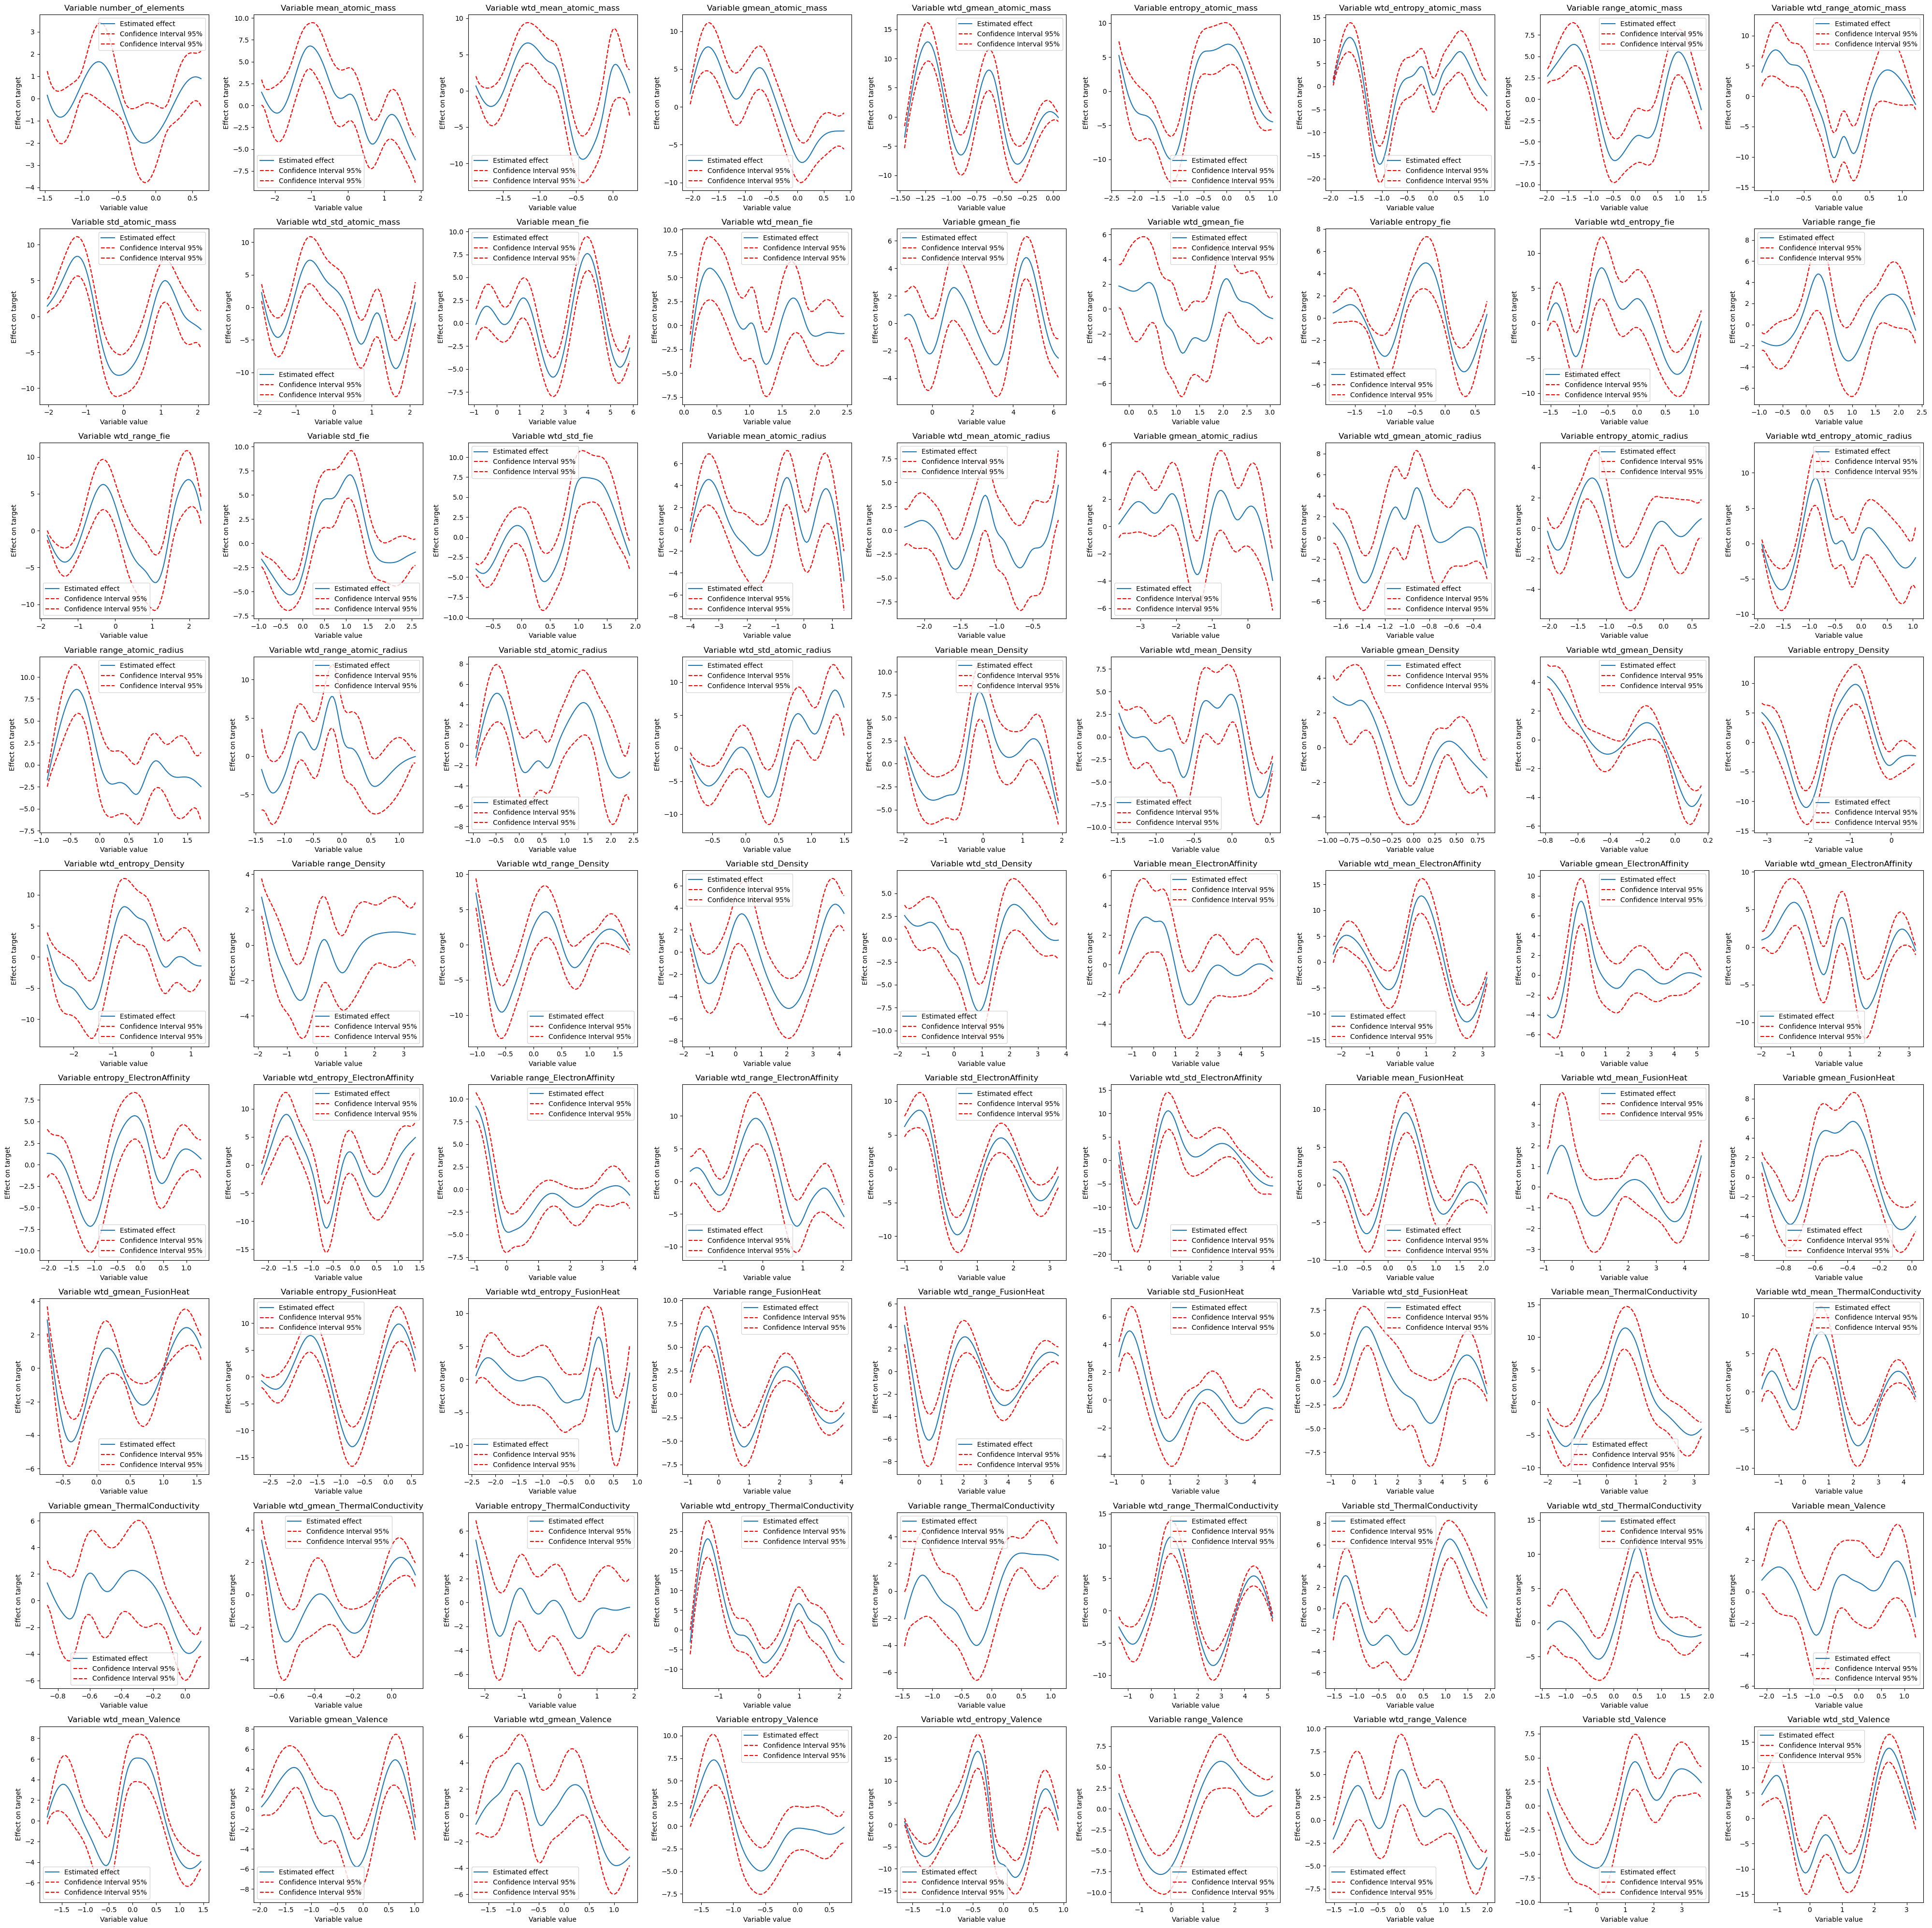

In [44]:
gam.partial_dependence_plot(cluster=0)

We have so many features here! To help us to visualize only the most important ones, we can use the calculated shap values to identify $k$ most relevant features.

In [51]:
cluster_0_sv

.values =
array([[-1.00305613e+00,  1.43817098e-01, -3.61065333e+00, ...,
        -2.56937773e-01, -2.21619693e+00,  3.38165890e-01],
       [-1.00305613e+00,  1.43817098e-01, -3.58485518e+00, ...,
        -2.76138239e-01, -2.21619693e+00,  3.76078852e-01],
       [-1.00305620e+00,  1.43817098e-01, -2.44245171e+00, ...,
        -6.73696972e-01, -2.21619693e+00,  1.64617216e+00],
       ...,
       [ 2.56984684e+00, -5.07882581e+00, -4.07758278e+00, ...,
         5.53911932e+00,  4.84143214e+00,  1.68842172e+01],
       [-1.00305613e+00,  4.94072109e-03, -3.84469630e+00, ...,
        -3.73575577e-01, -2.21619693e+00,  5.86236887e-01],
       [-1.00305613e+00, -5.73039687e-02, -3.75364876e+00, ...,
        -6.34806919e-01, -2.66994660e+00,  2.36956773e-02]])

.base_values =
array([22.9915047, 22.9915047, 22.9915047, ..., 22.9915047, 22.9915047,
       22.9915047])

.data =
array([[-0.07796836, -0.36993965, -0.46764343, ..., -0.37022348,
        -0.83529386, -0.49832668],
       [-0.07796

In this array, ``values`` contain shap values, while ``base_values`` represent the expected value of the model output and ``data`` correspond to the original data. With this, we can identify the most important features by making the mean of shap values across all the instances for each feature. 

In [56]:
mean_abs_shap_values = np.abs(cluster_0_sv.values).mean(0)

feature_importance_cluster0 = pd.DataFrame({
        'feature': X_train.columns,
        'importance': mean_abs_shap_values
    })
feature_importance_cluster0 = feature_importance_cluster0.sort_values(by='importance', ascending=False)

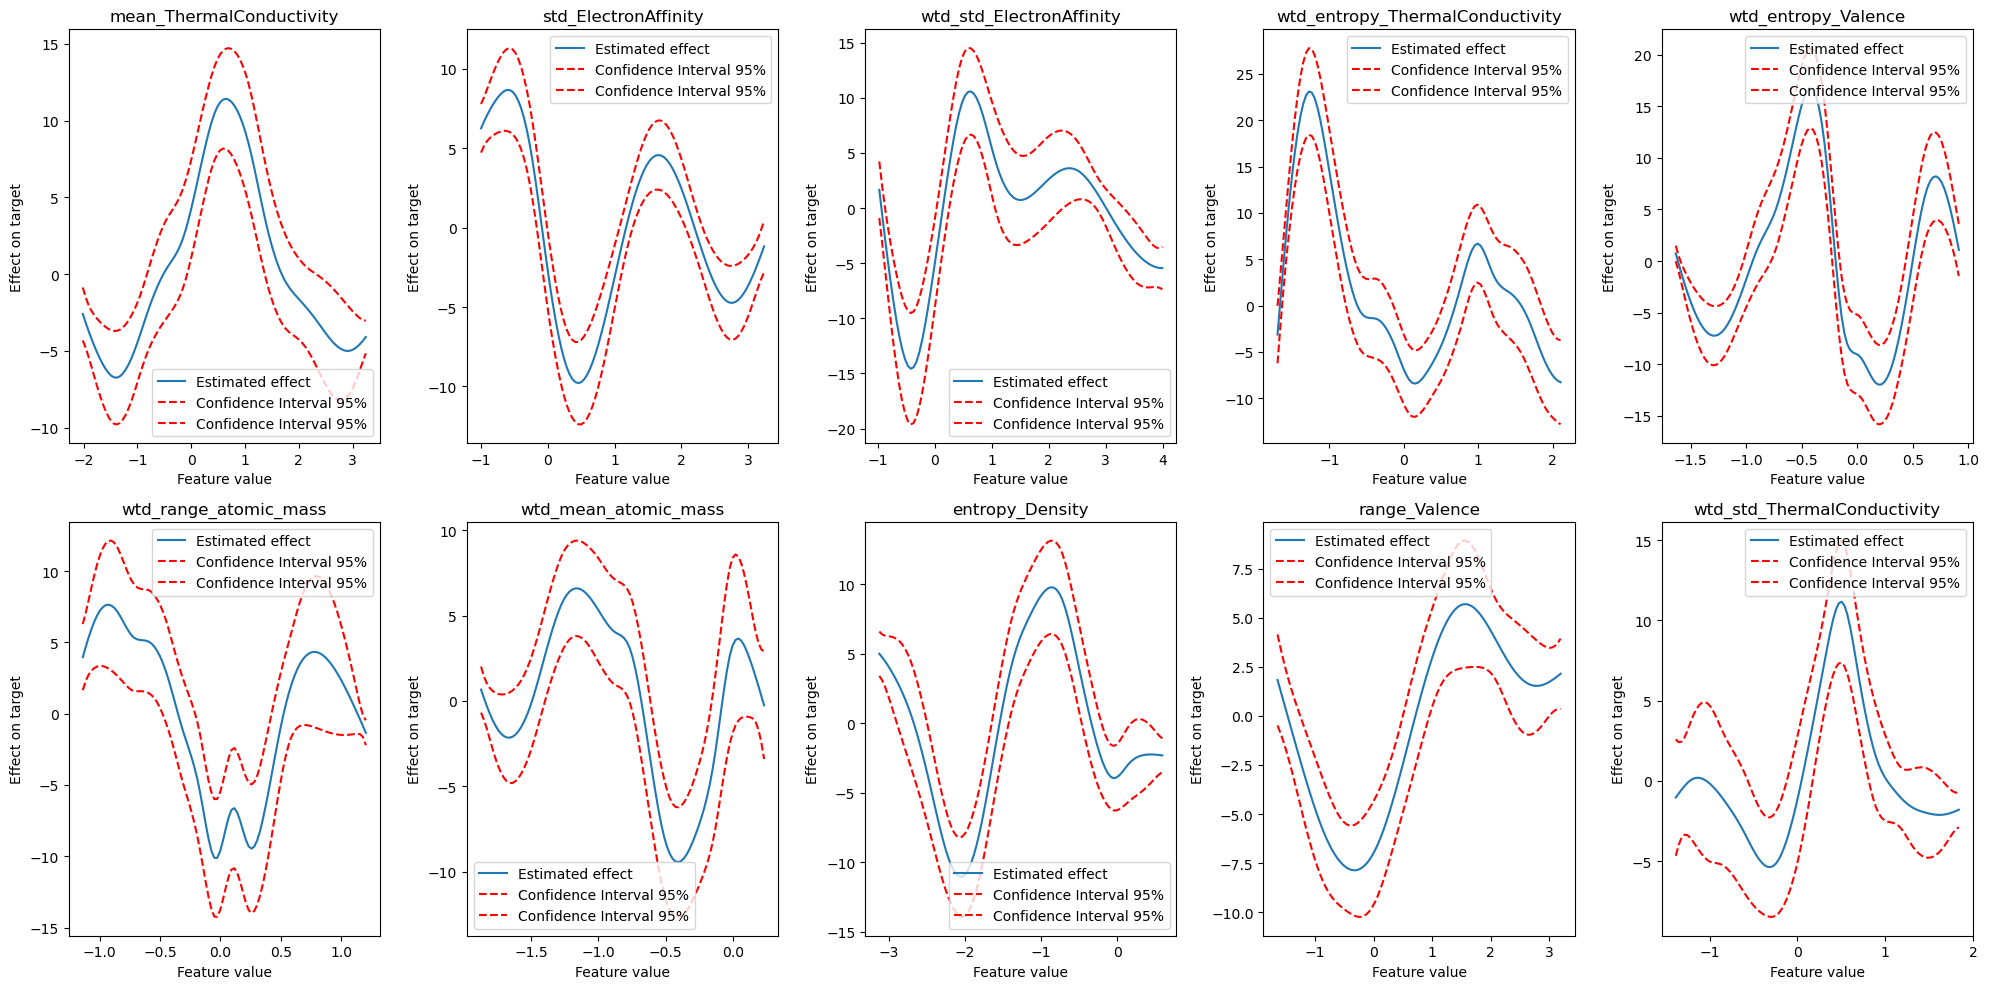

In [64]:
num_vars = 10
top_features = feature_importance_cluster0.head(num_vars)
top_indices = [X_train.columns.get_loc(f) for f in top_features['feature']]

fig, axs = plt.subplots(2, 5, figsize=(20, 10))
axs = axs.flatten()

for idx, feature_idx in enumerate(top_indices):
    XX = gam.models_[0].generate_X_grid(term=feature_idx)
    y_partial, y_conf = gam.models_[0].partial_dependence(term=feature_idx, X=XX, width=0.95)

    axs[idx].plot(XX[:, feature_idx], y_partial, label="Estimated effect")
    axs[idx].plot(XX[:, feature_idx], y_conf, c='r', ls='--', label="Confidence Interval 95%")
    
    feature_name = X_train.columns[feature_idx]
    axs[idx].set_title(f"{feature_name}")
    axs[idx].set_xlabel("Feature value")
    axs[idx].set_ylabel("Effect on target")
    axs[idx].legend()

plt.tight_layout()
plt.show()

### 🤔 **Conclusions**

At the end of the analysis, it is possible to notice that SHAP is an indispensable tool for interpreting machine learning models, due to its versatility and user-friendly API. However, some tools from the libraries used to train the models can also assist in this analysis.

### 🗂️ **References!**

[1] Sun, K., Lan, T., Goh, Y. M., Safiena, S., Huang, Y.-H., Lytle, B., & He, Y. (2024). An interpretable clustering approach to safety climate analysis: Examining driver group distinctions. Accident Analysis & Prevention, 196, 107420. https://doi.org/10.1016/j.aap.2023.107420

[2] Welcome to the SHAP documentation—SHAP latest documentation. ([s.d.]). Recuperado 29 de agosto de 2025, de https://shap.readthedocs.io/en/latest/

[3] Cassargroup/explicable-ai-supercondutores. (2025). [Jupyter Notebook]. CassarGroup. https://github.com/CassarGroup/Explicable-AI-Supercondutores (Trabalho original publicado 2025)
